# **Deep Learning - Competition 1** 
108024507 張文騰 
108024512 吳紹丞
108024519 劉怡禎
109062659 蘇瑞揚


# ***Import Package and datasets***



In [ ]:
import requests
import os
import itertools
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import lightgbm as lgb
import nltk
import inspect
import datetime
from sklearn.svm import LinearSVC

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.feature_selection import RFE

import xgboost as xgb

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# from google.colab import files
# uploaded = files.upload()
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

欲預測變數 Popularity 在 training set 中，-1與1的比例為 13632 : 14011，比例相當

In [ ]:
downloaded = drive.CreateFile({'id':"1T5V0pxt6GRAXeDP_2plYgtNo__JzUQjc"})   # replace the id with id of file you want to access
downloaded.GetContentFile("train.csv") 
X = pd.read_csv("train.csv")
y = np.array(X['Popularity'])


# required further adjust, since like there exists better way to transfrom 

y_new = np.ones(len(y))

for i in range(len(y)):
  if(y[i]==-1):
    y_new[i] = 0
  else:
    y_new[i] = 1
# del X['Popularity']

In [ ]:
X

,Id,Popularity,Page content
0,0,-1,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."
2,2,1,"<html><head><div class=""article-info""><span cl..."
3,3,-1,"<html><head><div class=""article-info""><span cl..."
4,4,-1,"<html><head><div class=""article-info""><span cl..."
...,...,...,...
27638,27638,-1,"<html><head><div class=""article-info""><span cl..."
27639,27639,-1,"<html><head><div class=""article-info""><span cl..."
27640,27640,-1,"<html><head><div class=""article-info""><span cl..."
27641,27641,-1,"<html><head><div class=""article-info""><span cl..."


In [ ]:
downloaded = drive.CreateFile({'id':"1pMSo4b5AHZBB5napuAQMaym5lZePK9FO"})   # replace the id with id of file you want to access
downloaded.GetContentFile("test.csv") 
X_test = pd.read_csv("test.csv")

In [ ]:
X_test

,Id,Page content
0,27643,"<html><head><div class=""article-info""><span cl..."
1,27644,"<html><head><div class=""article-info""><span cl..."
2,27645,"<html><head><div class=""article-info""><span cl..."
3,27646,"<html><head><div class=""article-info""><span cl..."
4,27647,"<html><head><div class=""article-info""><span cl..."
...,...,...
11842,39485,"<html><head><div class=""article-info""><span cl..."
11843,39486,"<html><head><div class=""article-info""><span cl..."
11844,39487,"<html><head><div class=""article-info""><span cl..."
11845,39488,"<html><head><div class=""article-info""><span cl..."


# ***Preprocess Data***

1.   Data Cleaning
2.   Feature Enginerring



## ***1. Data Cleaning***

由於Page content裡存的是html的資料型態，因此先將其去除，取出只有文字的部分。

In [ ]:
soup_train = BeautifulSoup(X['Page content'][1],"lxml") # lxml or html.parser (different parsers)
soup_test = BeautifulSoup(X_test['Page content'][1],"lxml") # lxml or html.parser (different parsers)
# print(soup_train.prettify())

## ***2. Feature Engineering***

### **Create Variables About Articles**

將從 Page content 取出的文字分為 **標題**、**主題**與**內容**，並從中得到新變數 :
1. 讀文章時，通常最先瀏覽標題長短，才會選擇是否點擊觀看 ; 文章尾端的主題會影響讀者在網路上搜尋關鍵字的的點擊率 ; 文章篇幅長度直觀而言亦與受歡迎相關，因此將**三者單字數、字元數**當作變數

2. 在許多新聞平台及部落格文章平台經常看到**文章標題中具數字**來吸引讀者點閱，例如 5 most inspirational speeches、8 Habits of Quiet Winners，故將此做為一變數

3. 標題中的標點符號能給予文字情緒起伏，將**標點符號量**視為一變數

4. 在文章尾端的主題會影響讀者在網路上搜尋關鍵字的的點擊率，故取主題數量作一變數，以 Topic 出現次數及文章受歡迎與否定義 topic value，分出 **good topics 及 bad topics** 變數

5. 考量到**文章連結到的外部平台**可能增加文章點擊率，例如 : Twitter.Youtube，故作為一變數

6. 以 Popularity 與發文作者分為 **good author 及 bad author**

7. **文章中段落個數**可能影響讀者觀看感受，故將此納入變數

8. 以 Popularity 與文章類型分為**good article class、bad article class**

9. 文章中**圖片數量**也可能與受歡迎與否相關，故納入變數


#### Extract the title name, topics and content


In [ ]:
# (--- time consuming ---)
title_tag_list_train = []

for i in range(X.shape[0]):
    soup_train = BeautifulSoup(X['Page content'][i],"lxml")
    title_tag = soup_train.find('h1')
    title_tag_list_train.append(title_tag.string)

title_tag_list_test = []

for i in range(X_test.shape[0]):
    soup_test = BeautifulSoup(X_test['Page content'][i],"lxml")
    title_tag = soup_test.find('h1')
    title_tag_list_test.append(title_tag.string)

#### Count the number of characters in the title


In [ ]:
# Count the number of characters per title
title_tag_totalcharacter_count_train = []

for title_tag in title_tag_list_train:
  title_tag_totalcharacter_count_temp = len(title_tag)
  title_tag_totalcharacter_count_train.append(title_tag_totalcharacter_count_temp)

title_tag_totalcharacter_count_test = []

for title_tag in title_tag_list_test:
  title_tag_totalcharacter_count_temp = len(title_tag)
  title_tag_totalcharacter_count_test.append(title_tag_totalcharacter_count_temp)

In [ ]:
X['title_tag_totalcharacter_count'] = title_tag_totalcharacter_count_train
X_test['title_tag_totalcharacter_count'] = title_tag_totalcharacter_count_test
display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count
0,0,-1,"<html><head><div class=""article-info""> <span c...",60
1,1,1,"<html><head><div class=""article-info""><span cl...",74
2,2,1,"<html><head><div class=""article-info""><span cl...",68
3,3,-1,"<html><head><div class=""article-info""><span cl...",43
4,4,-1,"<html><head><div class=""article-info""><span cl...",61


,Id,Page content,title_tag_totalcharacter_count
0,27643,"<html><head><div class=""article-info""><span cl...",74
1,27644,"<html><head><div class=""article-info""><span cl...",36
2,27645,"<html><head><div class=""article-info""><span cl...",46
3,27646,"<html><head><div class=""article-info""><span cl...",40
4,27647,"<html><head><div class=""article-info""><span cl...",70


#### Count the number of string in the title

In [ ]:
# Count the number of strings per title

title_tag_totalstring_count_train = []

for title_tag in title_tag_list_train:
  title_tag_totalstring_count_temp = title_tag.count(" ")+1
  title_tag_totalstring_count_train.append(title_tag_totalstring_count_temp)

title_tag_totalstring_count_test = []

for title_tag in title_tag_list_test:
  title_tag_totalstring_count_temp = title_tag.count(" ")+1
  title_tag_totalstring_count_test.append(title_tag_totalstring_count_temp)

In [ ]:
X['title_tag_totalstring_count'] = title_tag_totalstring_count_train
X_test['title_tag_totalstring_count'] = title_tag_totalstring_count_test
display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12
2,2,1,"<html><head><div class=""article-info""><span cl...",68,12
3,3,-1,"<html><head><div class=""article-info""><span cl...",43,5
4,4,-1,"<html><head><div class=""article-info""><span cl...",61,10


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count
0,27643,"<html><head><div class=""article-info""><span cl...",74,11
1,27644,"<html><head><div class=""article-info""><span cl...",36,6
2,27645,"<html><head><div class=""article-info""><span cl...",46,8
3,27646,"<html><head><div class=""article-info""><span cl...",40,6
4,27647,"<html><head><div class=""article-info""><span cl...",70,12


#### Check if there exists digits in the title



In [ ]:
# Create Binary Column: 1: title contains digit, 0: opposite

def contain_digit(list_):
  contains_digit_list = []
  for title_tag in list_:
    contains_digit_list_temp = []
    for character in title_tag:
      contains_digit_list_temp.append(character.isdigit())
    if(np.sum(contains_digit_list_temp)>0):
      contains_digit_list.append(1)
    else:
      contains_digit_list.append(0)
  return(contains_digit_list)

contain_digit_train = contain_digit(title_tag_list_train)
contain_digit_test = contain_digit(title_tag_list_test)

In [ ]:
X['contain_digit'] = contain_digit_train
X_test['contain_digit'] = contain_digit_test
display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0
2,2,1,"<html><head><div class=""article-info""><span cl...",68,12,1
3,3,-1,"<html><head><div class=""article-info""><span cl...",43,5,0
4,4,-1,"<html><head><div class=""article-info""><span cl...",61,10,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0
2,27645,"<html><head><div class=""article-info""><span cl...",46,8,0
3,27646,"<html><head><div class=""article-info""><span cl...",40,6,0
4,27647,"<html><head><div class=""article-info""><span cl...",70,12,0


#### Count the numbers of punctuations in the title

In [ ]:
def count_punctuation(list_,punc):
  count_punctuation_list = [] 
  for title_tag in list_:
    count = 0;
    for character in title_tag:   
      #Checks whether given character is a punctuation mark  
      for i in range(len(character)):
        if character[i] in punc:  
          count = count + 1;  
    count_punctuation_list.append(count)
  return count_punctuation_list

punctuation = [","]

punctuation_count_comma_train = count_punctuation(title_tag_list_train,punctuation)
punctuation_count_comma_test = count_punctuation(title_tag_list_test,punctuation)

punctuation = ["!",":" ,"?"]

punctuation_count_ex_que_col_train = count_punctuation(title_tag_list_train,punctuation)
punctuation_count_ex_que_col_test = count_punctuation(title_tag_list_test,punctuation)

In [ ]:
X['punctuation_count_comma'] = punctuation_count_comma_train
X_test['punctuation_count_comma'] = punctuation_count_comma_test
X['punctuation_count_ex_que_col'] = punctuation_count_ex_que_col_train
X_test['punctuation_count_ex_que_col'] = punctuation_count_ex_que_col_test
display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1
2,2,1,"<html><head><div class=""article-info""><span cl...",68,12,1,0,1
3,3,-1,"<html><head><div class=""article-info""><span cl...",43,5,0,0,0
4,4,-1,"<html><head><div class=""article-info""><span cl...",61,10,0,0,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0
2,27645,"<html><head><div class=""article-info""><span cl...",46,8,0,0,0
3,27646,"<html><head><div class=""article-info""><span cl...",40,6,0,0,0
4,27647,"<html><head><div class=""article-info""><span cl...",70,12,0,0,1


In [ ]:
title_tag_a_train = []
soup_train = BeautifulSoup(X['Page content'][3],"lxml")
# print(soup_train.prettify())
soup_train.get_text()
[soup_train.find(attrs = {"class": "article-topics"}).get_text().split(', ')[0].split(': ')[1]] + soup_train.find(attrs = {"class": "article-topics"}).get_text().split(', ')[1:]
# tag_a = soup_train.find('title')
# title_tag_a_train.append(tag_a)

['Sports', 'Video', 'Videos', 'Watercooler ']

#### Get Topics being at the bottom of the article


In [ ]:
# (11422 row displace its <footer>!!!) (---time consuming---)

def find_topic(dataframe):
  article_topics_list = []
  for i in range(dataframe.shape[0]):
    soup_train = BeautifulSoup(dataframe['Page content'][i],"lxml")
    # strip(): to remove leading and trailing spaces
    # since 11422 row has some problem with the location of footer being behind the <script>, have already tried .select and .select_one
    if i!=11422:
      article_topics_list_temp = soup_train.find(attrs = {"class": "article-topics"}).get_text().strip().split(', ')
      # remove 'Topic: ' and concatenate the topic(e.g. Sports from Topic: Sports) with the following other topics  
      if(len(article_topics_list_temp)>1):
        article_topics_list.append([article_topics_list_temp[0].split(': ')[1]] + article_topics_list_temp[1:])
      else:
        article_topics_list.append(['NA'])
    else:
      article_topics_list.append(['NA'])
  return article_topics_list

In [ ]:
topic_train = find_topic(X)
topic_test = find_topic(X_test)

In [ ]:
# find the length of topic for each article

def topic_length_generator(list_):
  topic_len = []
  for i in range(len(list_)):
    topic_len.append(len(list_[i]))
  return topic_len

In [ ]:
X['topic_len'] = topic_length_generator(topic_train)
X_test['topic_len'] = topic_length_generator(topic_test)

In [ ]:
# count the total topics of occurence

all_train_topics = [topic_train_list_item for topic_train_list in topic_train for topic_train_list_item in topic_train_list ]
all_train_topics_uni = list(set(all_train_topics))
all_train_topics_uni_count = [(all_train_topics_uni[idx], all_train_topics.count(all_train_topics_uni[idx])) for idx in range(len(all_train_topics_uni))]

In [ ]:
# find the index for y = 1

y_new_index = [idx for (idx,y_new[idx]) in enumerate(y_new) if y_new[idx]==1]
all_train_topics_list_yone = [topic_train[i] for i in y_new_index]
print(len(all_train_topics_list_yone))
all_train_topics_list_yone_topics = [topic_train_list_item for topic_train_list in all_train_topics_list_yone for topic_train_list_item in topic_train_list]
all_train_topics_yone_uni = list(set(all_train_topics_list_yone_topics))
all_train_topics_yone_uni_count = [(all_train_topics_yone_uni[idx], all_train_topics_list_yone_topics.count(all_train_topics_yone_uni[idx])) for idx in range(len(all_train_topics_yone_uni))]
all_train_topics_yone_uni_count

13632


[('translation', 2),
 ('Ryan Lewis', 2),
 ('amazon instant video', 5),
 ('Smithsonian Museum', 1),
 ('nyc taxi', 1),
 ('facebookp', 1),
 ('commmunity challenge', 1),
 ('radiohead', 1),
 ('friendship', 4),
 ('Rebecca Black', 2),
 ('weekend getaway', 1),
 ('website down', 1),
 ('extrafabulous comics', 1),
 ('Lima', 1),
 ('call of duty advance warfare', 1),
 ('Uganda', 1),
 ('3g', 2),
 ('beginning 2014', 6),
 ('throwback', 1),
 ('animated movie', 1),
 ('transit maps', 1),
 ('fda', 9),
 ('Jason Reitman', 1),
 ('eink', 1),
 ('Apocolypse', 1),
 ('NFL Draft', 6),
 ('e-ink', 2),
 ('mariah carey', 4),
 ('Obama Adminstration', 1),
 ('Red', 1),
 ('motion control', 4),
 ('Goldbely', 1),
 ('Browsers', 1),
 ('graphing calculator', 1),
 ('alien planets', 6),
 ('disaster', 7),
 ('love & hip hop', 1),
 ('Droid Turbo', 1),
 ('nypd shooting', 1),
 ('military', 21),
 ('Jim Roberts', 1),
 ('americana', 1),
 ('corporate', 1),
 ('John Stamos', 2),
 ('online storage', 1),
 ('Memorial Day weekend', 1),
 ('adel

In [ ]:
# find which topics from are in the topics with y = 1

all_train_topics_in_yone = []
for i in range(len(all_train_topics_uni_count)):
  if(all_train_topics_uni_count[i][0] in list(zip(*all_train_topics_yone_uni_count))[0]):
    all_train_topics_in_yone.append((all_train_topics_uni_count[i]))

In [ ]:
# make sure the value is indexed in the right order
all_train_topics_in_yone = sorted(all_train_topics_in_yone)
all_train_topics_yone_uni_count = sorted(all_train_topics_yone_uni_count)

# compute ratio
all_train_topics_ratio = [(all_train_topics_in_yone[idx][0],all_train_topics_in_yone[idx][1],all_train_topics_yone_uni_count[idx][1] ,round(all_train_topics_yone_uni_count[idx][1]/all_train_topics_in_yone[idx][1],4)) for idx in range(len(all_train_topics_in_yone))]
# ratio from high to low
all_train_topics_ratio_with_freq = sorted(all_train_topics_ratio,key=lambda x: -x[3])

In [ ]:
print(np.quantile(list(zip(*all_train_topics_ratio_with_freq))[1],0.99)) # top 1% threshold of topic occurence = 28
train_topics_result = sorted([all_train_topics_ratio_with_freq[idx] for idx in range(len(all_train_topics_ratio_with_freq)) if all_train_topics_ratio_with_freq[idx][1]>171.93], key=lambda x: -x[3])

good_topics = [topic[0] for (idx,topic) in enumerate(train_topics_result) if train_topics_result[idx][3]>=0.6]
bad_topics = [topic[0] for (idx,topic) in enumerate(train_topics_result) if train_topics_result[idx][3]<=0.4]

171.9399999999987


In [ ]:
X['topic'] = topic_train
X_test['topic'] = topic_test

In [ ]:
def topic_score_converter(dataframe):
  good_score = np.zeros(dataframe.shape[0])
  bad_score = np.zeros(dataframe.shape[0])
  for i in range(dataframe.shape[0]):
    for topic in dataframe['topic'][i]:
      if topic in good_topics:
        good_score[i] += 1
      elif topic in bad_topics:
        bad_score[i] -= 1
  return good_score, bad_score

In [ ]:
good_topic_score_train, bad_topic_score_train = topic_score_converter(X)
good_topic_score_test, bad_topic_score_test = topic_score_converter(X_test)
total_score_train = good_topic_score_train+bad_topic_score_train
total_score_test = good_topic_score_test+bad_topic_score_test

In [ ]:
X['good_topic_score'] = good_topic_score_train
X['bad_topic_score'] = bad_topic_score_train
X['total_topic_score'] = total_score_train
X_test['good_topic_score'] = good_topic_score_test
X_test['bad_topic_score'] = bad_topic_score_test
X_test['total_topic_score'] = total_score_test

In [ ]:
display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",0.0,0.0,0.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,0,2,1,clara moskowitz,soso,bad,0.25,0.5,16,4,1,-1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,soso_article_class,8,2,87,soso,0,0,2,0,0,christina warren,soso,soso,6.25,-2.5,169,13,0,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,soso_article_class,22,1,252,soso,0,0,0,1,0,sam laird,soso,bad,12.25,3.5,36,-6,9,-3
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,soso_article_class,7,3,304,soso,0,1,0,1,0,stan schroeder,soso,bad,20.25,4.5,256,16,0,0


#### Extract href related features (Twitter, number of href etc)


In [ ]:
# extract features from href (tag_a) e.g. total href, clickable link, number of twitter (---time consuming--- around 2.5 mins)

def extract_href(dataframe):
  
  count_href_total_list = []
  count_href_link_list = []
  count_href_twitter_list = []
  
  for i in range(dataframe.shape[0]):
    soup = BeautifulSoup(dataframe['Page content'][i], "lxml")
    tag_a = soup.find_all('a')

    count_href_total_list.append(len(tag_a))

    count_href_link = 0
    count_href_twitter = 0

    for j in range(len(tag_a)):
      count_href_link += int(str(tag_a[j]).find('http')>0) 
      count_href_twitter += int(str(tag_a[j]).find('twitter')>0)
    
    count_href_link_list.append(count_href_link)
    count_href_twitter_list.append(count_href_twitter)
  
  return (count_href_total_list, count_href_link_list, count_href_twitter_list)

In [ ]:
count_href_total_list_train, count_href_link_list_train, count_href_twitter_list_train = extract_href(X)
count_href_total_list_test, count_href_link_list_test, count_href_twitter_list_test = extract_href(X_test)

In [ ]:
print(count_href_total_list_train[0:10])
print(count_href_link_list_train[0:10])
print(count_href_twitter_list_train[0:10])
print(count_href_total_list_test[0:10])
print(count_href_link_list_test[0:10])
print(count_href_twitter_list_test[0:10])

[22, 18, 11, 13, 16, 30, 11, 13, 14, 13]
[14, 9, 5, 8, 10, 19, 3, 9, 7, 8]
[0, 0, 0, 0, 1, 0, 0, 2, 0, 2]
[30, 13, 13, 15, 10, 6, 22, 10, 17, 23]
[24, 6, 8, 7, 2, 2, 15, 5, 11, 12]
[9, 0, 0, 0, 0, 0, 12, 1, 0, 0]


In [ ]:
X['count_href_total'] = count_href_total_list_train
X['count_href_link'] = count_href_link_list_train
X['count_href_twitter'] = count_href_twitter_list_train
X_test['count_href_total'] = count_href_total_list_test
X_test['count_href_link'] = count_href_link_list_test
X_test['count_href_twitter'] = count_href_twitter_list_test

display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0
2,2,1,"<html><head><div class=""article-info""><span cl...",68,12,1,0,1,5,"[Entertainment, NFL, NFL Draft, Sports, Televi...",0.0,0.0,0.0,11,5,0
3,3,-1,"<html><head><div class=""article-info""><span cl...",43,5,0,0,0,4,"[Sports, Video, Videos, Watercooler]",0.0,0.0,0.0,13,8,0
4,4,-1,"<html><head><div class=""article-info""><span cl...",61,10,0,0,0,5,"[Entertainment, instagram, instagram video, NF...",0.0,0.0,0.0,16,10,1


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0
2,27645,"<html><head><div class=""article-info""><span cl...",46,8,0,0,0,4,"[amazon, amazon kindle, Business, Gaming]",0.0,0.0,0.0,13,8,0
3,27646,"<html><head><div class=""article-info""><span cl...",40,6,0,0,0,7,"[Between Two Ferns, Movies, The Oscars, Oscars...",0.0,0.0,0.0,15,7,0
4,27647,"<html><head><div class=""article-info""><span cl...",70,12,0,0,1,7,"[American Sniper, Awards, Bradley Cooper, clin...",0.0,0.0,0.0,10,2,0


#### Find best author

In [ ]:
def author_fun(data):
  author = []
  for aut in range(data.shape[0]):
    soup = BeautifulSoup(data['Page content'][aut], "html.parser")
    tag = soup.find(class_ = "author_name")
    if tag is None: 
        if soup.find('span') is None:
            author.append("other")
        elif (soup.find('span').string) is None:
            author.append("other")    
        else :
            author.append(soup.find('span').string.lower().replace(',','').replace('by',''))
    elif (soup.find('span')) is None:
      author.append(soup.find("a").get_text().lower().replace(',','').replace('by',''))
    elif (tag.select_one('a')) is None:
      author.append(tag.string.lower().replace(',','').replace('by',''))
    else:
      author.append(tag.select_one('a').string.lower().replace(',','').replace('by',''))
  return author  

In [ ]:
X['author'] = author_fun(X)
X_test['author'] = author_fun(X_test)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


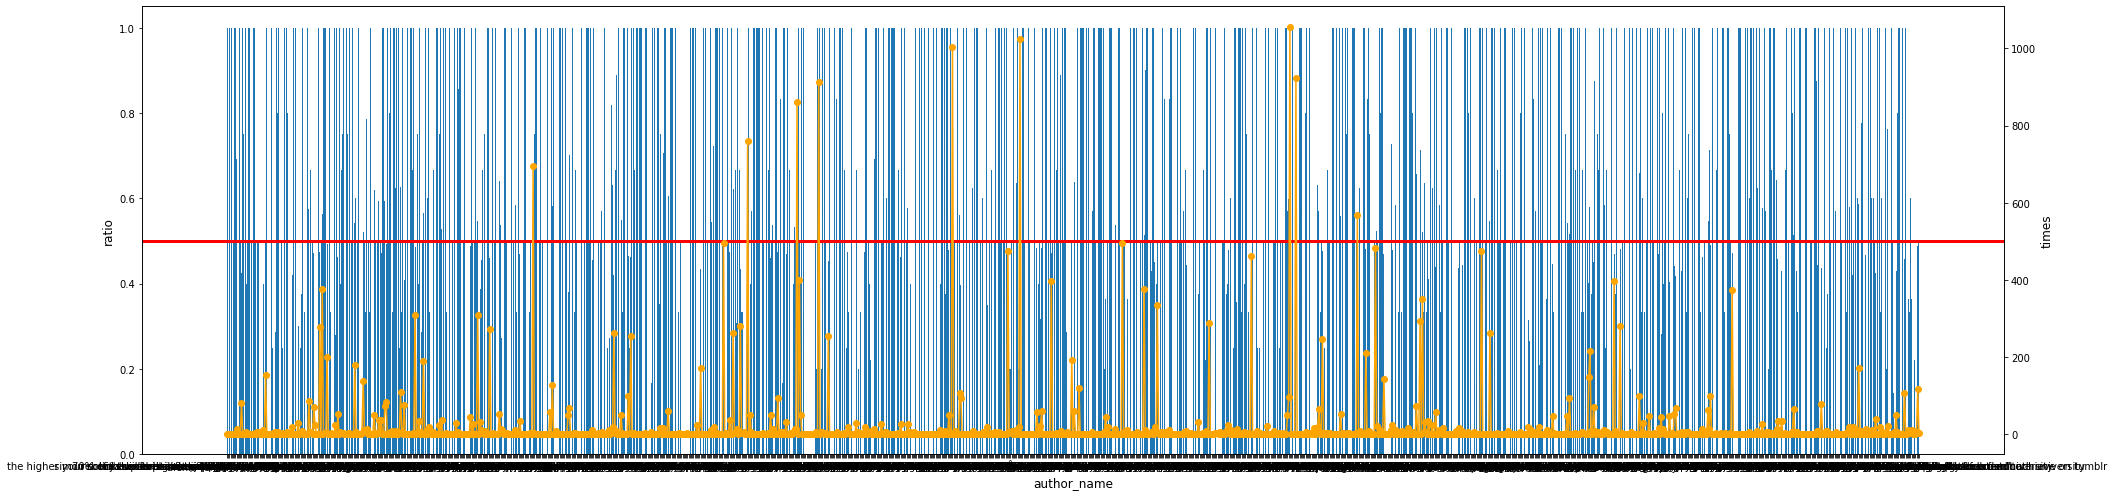

In [ ]:
# --time consuming--

author_name_list_unique = list(set(X['author']))
author_name_list_yone_list = list(compress(X['author'], y==1))
author_name_y_list = list(zip(*(y, X['author'])))
author_name_list_yone = [(author_name_list_unique[idx], author_name_list_yone_list.count(i)) for (idx, i) in enumerate(author_name_list_unique)]
author_name_list_all = [(author_name_list_unique[idx], list(X['author']).count(i)) for (idx, i) in enumerate(author_name_list_unique)]
author_name_ratio = [(author_name_list_unique[i], round(author_name_list_yone[i][1] / author_name_list_all[i][1],4)) for i in range(len(author_name_list_unique))]

fig, ax = plt.subplots(figsize=(30,7))

ax.bar(list(zip(*author_name_ratio))[0],list(zip(*author_name_ratio))[1])
ax.set_xlabel("author_name",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(range(len(author_name_list_unique)))

ax2 = ax.twinx()
ax2.plot(list(zip(*author_name_ratio))[0],list(zip(*author_name_list_all))[1], marker = 'o', color = 'orange')
ax2.set_ylabel("times",fontsize=12)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
def author_threshold(list_1,list_2,p):
  author_index100_list = []
  for (aut, quantity) in list_1:
    if(quantity>=100):
      author_index100_list.append(aut)

  author_indexp_list = []
  for (aut, rat) in list_2:
    if p > 0.5:
      if rat>=p:
        author_indexp_list.append(aut)
    else:
      if rat<=p:
        author_indexp_list.append(aut)

  author_segmentation = list(set(author_indexp_list).intersection(set(author_index100_list))) 
  return author_segmentation

good_author = author_threshold(author_name_list_all,author_name_ratio,0.6)
bad_author = author_threshold(author_name_list_all,author_name_ratio,0.4)
print(good_author)
print(bad_author)

['anita li', 'camille bautista', 'matt petronzio', 'charlie white']
['alex fitzpatrick']


In [ ]:
for best_author in good_author:
    print(best_author,':',list(zip(*author_name_list_all))[1][list(zip(*author_name_list_all))[0].index(best_author)])
    print(best_author,':',list(zip(*author_name_ratio))[1][list(zip(*author_name_list_all))[0].index(best_author)])

anita li : 293
anita li : 0.7133
camille bautista : 110
camille bautista : 0.6273
matt petronzio : 262
matt petronzio : 0.6221
charlie white : 100
charlie white : 0.66


In [ ]:
def author_converter(dataframe):
  author_convert_list = []
  for i in range(dataframe.shape[0]):
    if dataframe['author'][i] in good_author:
      author_convert_list.append('good')
    elif dataframe['author'][i] in bad_author:
      author_convert_list.append('bad')
    else:
      author_convert_list.append('soso')
  return author_convert_list

In [ ]:
author_train = author_converter(X)
author_test = author_converter(X_test)

X['author_label'] = author_train
X_test['author_label'] = author_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,0,2,1,clara moskowitz,soso
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87,soso,0,0,2,0,0,christina warren,soso


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252,soso,0,0,0,1,0,sam laird,soso
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304,soso,0,1,0,1,0,stan schroeder,soso


#### Extract the number of paragraph


In [ ]:
def count_paragraph(dataframe):
  par_count = []
  for i in range(dataframe.shape[0]):
    soup = BeautifulSoup(dataframe['Page content'][i])
    par = []
    for string in str(soup.find_all('p')).split('</p>'):
      par.append(string)
    par_count.append(len(par)-1)

  return par_count

In [ ]:
par_count_train = count_paragraph(X)
par_count_test = count_paragraph(X_test)

In [ ]:
X['par_count'] = par_count_train 
X_test['par_count'] = par_count_test 

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7


#### Extract the article type (e.g. world, business...)
下圖 EDA 藍色部分為每個文章類型的 popular ratio，其中social-media、life style具較高 popular ratio，world較低，故分為 good article class、bad article class

In [ ]:
#  (---time consuming---)

def Extract_article_class(dataframe):
  article_class = []
  for i in range(dataframe.shape[0]):
    soup = BeautifulSoup(dataframe['Page content'][i], 'lxml')
    article_class.append(soup.article['data-channel'])
  return article_class

article_class_train = Extract_article_class(X)
article_class_test = Extract_article_class(X_test)

# check if there are any different elements between train and test, and yes, travel-leisure occurs in test but not in train 

print(set(article_class_train),'\n',len(set(article_class_train)))
print(set(article_class_test),'\n',len(set(article_class_test)))

print('Train > Test:',set(article_class_train).difference(set(article_class_test)))
print('Test > Train:',set(article_class_test).difference(set(article_class_train)))


# article_class_train['']
from itertools import compress

article_class_train_unique = list(set(article_class_train))

y_new_is_one = list(y_new==1)
y_new_is_one_article_class_train = list(compress(article_class_train, y_new_is_one ))

# when popularity = 1
article_class_train_unique_count_popularity_one = [(article_class_train_unique[idx] , y_new_is_one_article_class_train.count(i)) for (idx,i) in enumerate(article_class_train_unique)]
print(article_class_train_unique_count_popularity_one)

# length for each article_class
article_class_train_unique_count_all = [(article_class_train_unique[idx] , article_class_train.count(i)) for (idx,i) in enumerate(article_class_train_unique)]
print(article_class_train_unique_count_all)

def check_total(list_):
  total = 0
  for i in range(len(list_)):
    total += list_[i][1]
  return total

print(check_total(article_class_train_unique_count_popularity_one), y_new.sum())
print(check_total(article_class_train_unique_count_all),len(y_new))

article_class_ratio = dict()
j = 0
for i in range(len(article_class_train_unique)):
  if article_class_train_unique_count_all[i][1] > 500:
    article_class_ratio[article_class_train_unique[j]] = round(article_class_train_unique_count_popularity_one[i][1] / article_class_train_unique_count_all[i][1],4)
  j += 1

article_class_ratio

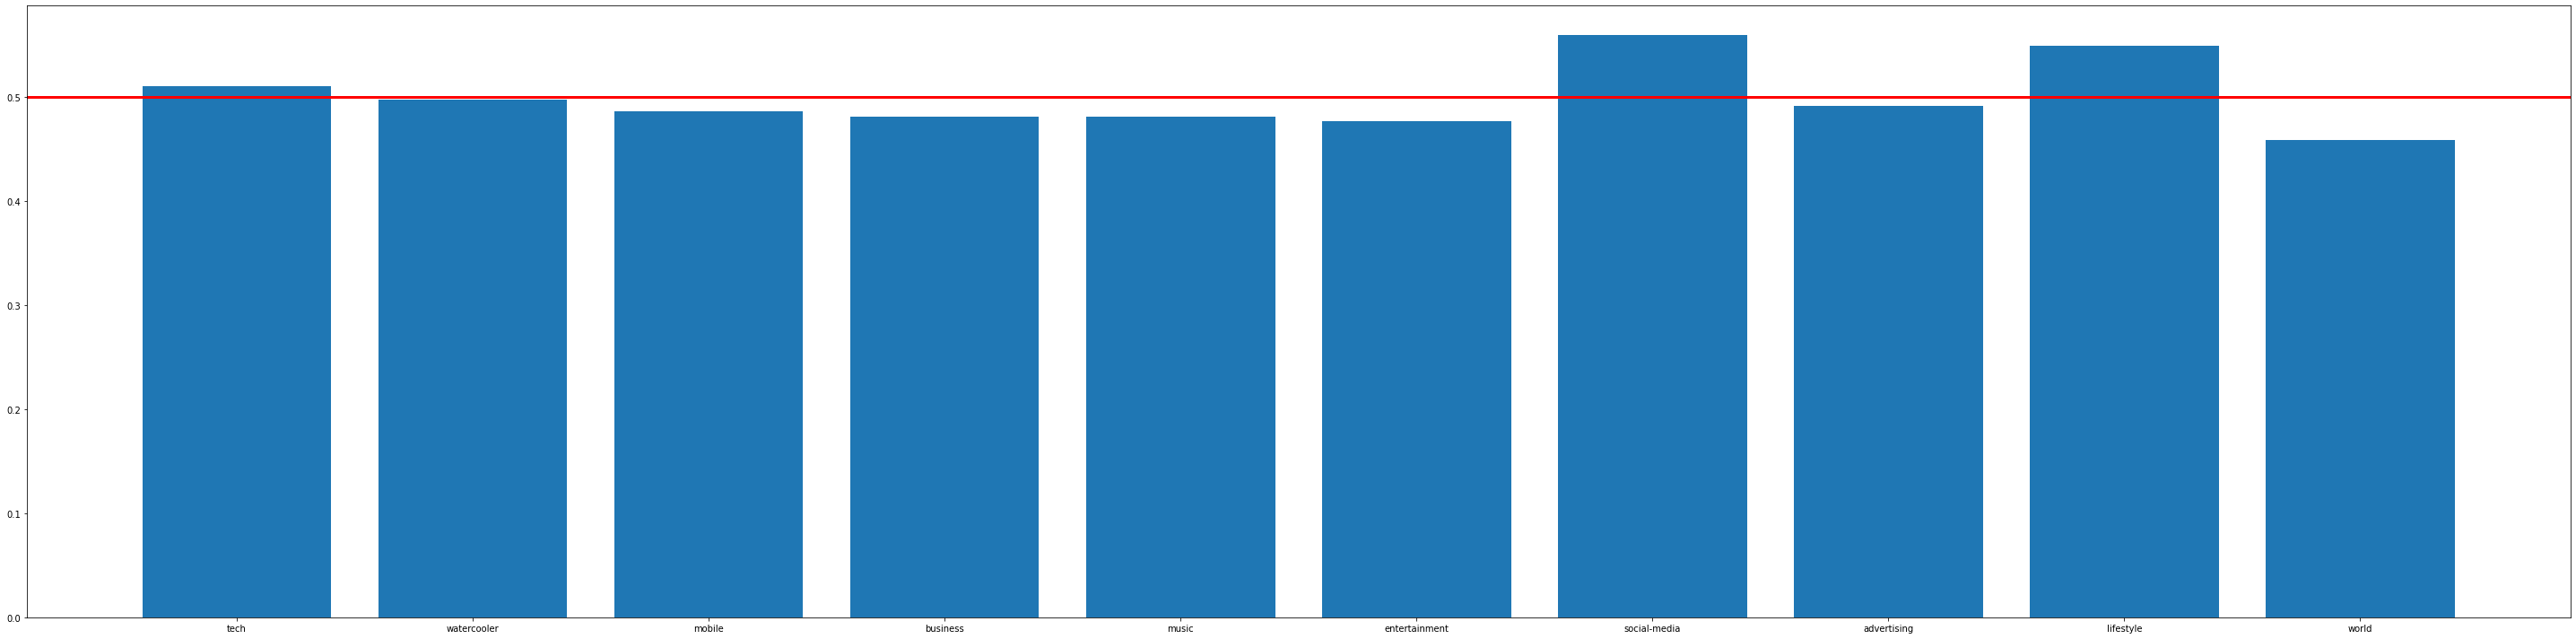

In [ ]:
article_class, ratio = zip(*article_class_ratio.items()) # unpack a list of pairs into two tuples

fig = plt.figure(figsize=(40,10))
ax = plt.axes()

plt.bar(article_class, ratio)
plt.tight_layout()
plt.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
good_article_class = []
bad_article_class = []
soso_article_class = []
for (title, prob) in article_class_ratio.items():
  if prob>=0.54:
    good_article_class.append(title)
  elif prob<=0.46:
    bad_article_class.append(title)
  else: 
    soso_article_class.append(title)

print(good_article_class)
print(bad_article_class)

['social-media', 'lifestyle']
['world']


In [ ]:
# transform the article class to pre-defined clusters
def transform_to_cluster(list_1):
  name = ['good_article_class','bad_article_class','soso_article_class']
  cluster = [''] * len(list_1)
  for idx in range(len(name)):
    for idx2, item in enumerate(list_1):
      if(item in eval(name[idx])):
        cluster[idx2] = name[idx]
  return cluster

In [ ]:
# transform and check

article_class_train_cluster = transform_to_cluster(article_class_train)
print(article_class_train_cluster.count('bad_article_class') + article_class_train_cluster.count('good_article_class'))
print(X.shape)

# Since 363 obv is trabel_leisure which is not in the training set, so randomly assign a class to it
article_class_test_cluster = transform_to_cluster(article_class_test)
article_class_test_cluster[363] = 'good_article_class'
print(article_class_test_cluster.count('bad_article_class') + article_class_test_cluster.count('good_article_class'))
print(X_test.shape)

7057
(27643, 52)
2979
(11847, 51)


In [ ]:
X['article_class'] = article_class_train_cluster
X_test['article_class'] = article_class_test_cluster
display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,0,2,1,clara moskowitz,soso,bad,0.25,0.5,16,4,1,-1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,soso_article_class,8,2,87,soso,0,0,2,0,0,christina warren,soso,soso,6.25,-2.5,169,13,0,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,soso_article_class,22,1,252,soso,0,0,0,1,0,sam laird,soso,bad,12.25,3.5,36,-6,9,-3
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,soso_article_class,7,3,304,soso,0,1,0,1,0,stan schroeder,soso,bad,20.25,4.5,256,16,0,0


In [ ]:
# # Subjective cluster

# # business: business, jobs, small-business, marketing, advertising, dev-design
# # technology: apps-software, startups
# # entertainment: music, media, social-media, film, socmed, gaming, gadgets, sports, travel-leisure (in testing data)
# # us: us
# # world: world 
# # life: watercooloer, pics, viral, mobile, memes, howto, lifestyle, comics, how-to, bus
# # human: mob (快閃), conversations, lifestyle, home,

# business_train = ["business", "jobs", "small-business", "marketing", "advertising", "dev-design", "startups"]
# technology_train = ["apps-software","tech"]
# entertainment_train = ["music", "media", "social-media", "film", "socmed", "gaming", "gadgets", "sports",'entertainment']
# world_train = ['world','us']
# life_train = ["watercooler", "pics", "viral", "mobile", "howto", "lifestyle", "comics", "how-to", "bus",'mob', 'conversations',  "home", "memes"]
# # human_train = ['mob', 'conversations',  "home", "memes"]

# def check_num_observation(list_,data_channel):
#   count = 0
#   for item in data_channel:
#     count += list_.count(item)
#   return count

# business_obs_train = check_num_observation(article_class_train, business_train)
# technology_obs_train = check_num_observation(article_class_train, technology_train)
# entertainment_obs_train = check_num_observation(article_class_train, entertainment_train)
# world_obs_train = check_num_observation(article_class_train, world_train)
# life_obs_train = check_num_observation(article_class_train, life_train)
# # human_obs_train = check_num_observation(article_class_train, human)

# business_test = ["business", "jobs", "small-business", "marketing", "advertising", "dev-design", "startups"]
# technology_test = ["apps-software", "tech"]
# entertainment_test = ["music", "media", "social-media", "film", "socmed", "gaming", "gadgets", "sports",'travel-leisure','entertainment']
# world_test = ['world','us']
# life_test = ["watercooler", "pics", "mobile", "memes", "lifestyle", "how-to",'mob', 'conversations',  "home"]
# # human = ['mob', 'conversations', "home"]

# business_obs_test = check_num_observation(article_class_test, business_test)
# technology_obs_test = check_num_observation(article_class_test, technology_test)
# entertainment_obs_test = check_num_observation(article_class_test, entertainment_test)
# world_obs_test = check_num_observation(article_class_test, world_test)
# life_obs_test = check_num_observation(article_class_test, life_test)
# # human_obs_test = check_num_observation(article_class_test, human)

# print('[Train]')
# print('business: {}, technology: {}, entertainment: {},  world: {}, life: {}'.format(business_obs_train,technology_obs_train, entertainment_obs_train, world_obs_train, life_obs_train))
# print('[Test]')
# print('business: {}, technology: {}, entertainment: {},  world: {}, life: {}'.format(business_obs_test,technology_obs_test, entertainment_obs_test, world_obs_test, life_obs_test))

#### Extract the number of images

In [ ]:
def count_image(dataframe):
  image_count = []
  for i in range(dataframe.shape[0]):
    soup = BeautifulSoup(dataframe['Page content'][i])
    image = []
    for img in str(soup.find_all('img')).split('<img'):
      image.append(img)
    image_count.append(len(image)-1)

  return image_count

In [ ]:
image_count_train = count_image(X)
image_count_test = count_image(X_test)

In [ ]:
X['image_count'] = image_count_train
X_test['image_count'] = image_count_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3


### **Create Variables About Date and Time**

#### Extract the date and time from html
文章的發佈時間、日期與受歡迎與否經常是息息相關的，以下是使用時間造出的新變數 :

1. 將發佈時間切為 morning (6-12), afternoon (12-18), evening (18-24), midnight (24-6) 時段

2. 分為工作日及假日。分為工作日及週六、週日

**以下為 EDA 後加入之新變數**

3. 以 Popularity 在一年中**發佈日期**中找到 good day of year 、bad day of year

4. 以 Popularity 將工作日、假日分為 good (六、日)、soso (五)、bad (一$\sim$ 四)

5. 以 Popularity 將**發佈時間**分為 good (5, 6, 8)、soso (2, 3, 4, 7, 9, 10, 11, 12, 13, 16, 21, 24)、bad (1, 14, 15, 17, 18, 19, 20, 22, 23)

6. 以 Popularity 將**發佈月份**分為 good (3, 4)、soso (1, 2, 5)、bad (6, 7, 8, 9, 10, 11, 12)

7. 以 Popularity 將**發佈分鐘**分為 good、soso、bad

8. 以 $(Month-5.5)、(Month-5.5)^2$
捕捉月份一、二階特徵; 

  以 $(Day-15)、(Day-15)^2$捕捉日一、二階特徵; 

  以 $(Week Day-3)、(Week Day-3)^2$捕捉禮拜幾的一、二階特徵

9. 以 Popularity 將**每月份週間日**分為 good month week、bad month week 
 

In [ ]:
def extract_time(dataframe):
  date_list = []
  time_list = []

  for i in range(dataframe.shape[0]):
    soup = BeautifulSoup(dataframe['Page content'][i], "lxml")
    try: # since 1585 row in testing_data occurs error while extracting
      date_time = soup.find('time').string.split(" ")
      date_list.append(date_time[0])
      time_list.append(date_time[1])
    except:
      date_list.append('NA')
      time_list.append('NA')

  return(date_list, time_list)

In [ ]:
date_list_train, time_list_train = extract_time(X)
date_list_test, time_list_test = extract_time(X_test)

In [ ]:
X['date_list'] = date_list_train
X['time_list'] = time_list_train
X_test['date_list'] = date_list_test
X_test['time_list'] = time_list_test

display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55
2,2,1,"<html><head><div class=""article-info""><span cl...",68,12,1,0,1,5,"[Entertainment, NFL, NFL Draft, Sports, Televi...",0.0,0.0,0.0,11,5,0,2014-05-07,19:15:20
3,3,-1,"<html><head><div class=""article-info""><span cl...",43,5,0,0,0,4,"[Sports, Video, Videos, Watercooler]",0.0,0.0,0.0,13,8,0,2013-10-11,02:26:50
4,4,-1,"<html><head><div class=""article-info""><span cl...",61,10,0,0,0,5,"[Entertainment, instagram, instagram video, NF...",0.0,0.0,0.0,16,10,1,2014-04-17,03:31:43


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02
2,27645,"<html><head><div class=""article-info""><span cl...",46,8,0,0,0,4,"[amazon, amazon kindle, Business, Gaming]",0.0,0.0,0.0,13,8,0,2013-06-25,12:54:54
3,27646,"<html><head><div class=""article-info""><span cl...",40,6,0,0,0,7,"[Between Two Ferns, Movies, The Oscars, Oscars...",0.0,0.0,0.0,15,7,0,2013-02-13,03:30:21
4,27647,"<html><head><div class=""article-info""><span cl...",70,12,0,0,1,7,"[American Sniper, Awards, Bradley Cooper, clin...",0.0,0.0,0.0,10,2,0,2014-10-03,01:34:54


#### Transform datetime to year, month, day, hour, minute, second

#### Divide hour into 4 partitions, morning(6-12), afternoon(12-18), evening(18-24), midnight(24-6)

In [ ]:
def hour_converter(dataframe):
  day_partition_list = []
  for i in range(dataframe.shape[0]):
    if (int(dataframe['hour'][i])>=0 and int(dataframe['hour'][i])<6):
      day_partition_list.append('midnight')
    elif (int(dataframe['hour'][i])>=6 and int(dataframe['hour'][i])<12):
      day_partition_list.append('morning')
    elif (int(dataframe['hour'][i])>=12 and int(dataframe['hour'][i])<18):
      day_partition_list.append('afternoon')
    else:
      day_partition_list.append('evening')
  return day_partition_list

In [ ]:
X['day_partition'] = hour_converter(X)
X_test['day_partition'] = hour_converter(X_test)

display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon
2,2,1,"<html><head><div class=""article-info""><span cl...",68,12,1,0,1,5,"[Entertainment, NFL, NFL Draft, Sports, Televi...",0.0,0.0,0.0,11,5,0,2014-05-07,19:15:20,2014,5,7,2,19,15,20,52,evening
3,3,-1,"<html><head><div class=""article-info""><span cl...",43,5,0,0,0,4,"[Sports, Video, Videos, Watercooler]",0.0,0.0,0.0,13,8,0,2013-10-11,02:26:50,2013,10,11,4,2,26,50,104,midnight
4,4,-1,"<html><head><div class=""article-info""><span cl...",61,10,0,0,0,5,"[Entertainment, instagram, instagram video, NF...",0.0,0.0,0.0,16,10,1,2014-04-17,03:31:43,2014,4,17,3,3,31,43,43,midnight


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning
2,27645,"<html><head><div class=""article-info""><span cl...",46,8,0,0,0,4,"[amazon, amazon kindle, Business, Gaming]",0.0,0.0,0.0,13,8,0,2013-06-25,12:54:54,2013,6,25,1,12,54,54,61,afternoon
3,27646,"<html><head><div class=""article-info""><span cl...",40,6,0,0,0,7,"[Between Two Ferns, Movies, The Oscars, Oscars...",0.0,0.0,0.0,15,7,0,2013-02-13,03:30:21,2013,2,13,2,3,30,21,22,midnight
4,27647,"<html><head><div class=""article-info""><span cl...",70,12,0,0,1,7,"[American Sniper, Awards, Bradley Cooper, clin...",0.0,0.0,0.0,10,2,0,2014-10-03,01:34:54,2014,10,3,4,1,34,54,104,midnight


#### Transform weekday to binary weekend

In [ ]:
def weekend_binary(dataframe):
  weekend_list = []
  for i in range(dataframe.shape[0]):
    if(dataframe['weekday'][i]>4):
      weekend_list.append(1)
    else:
      weekend_list.append(0)
  return weekend_list

In [ ]:
weekend_list_train = weekend_binary(X)
weekend_list_test = weekend_binary(X_test)

In [ ]:
X['is_weekend'] = weekend_list_train
X_test['is_weekend'] = weekend_list_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0


#### Transform weekday to binary workday

In [ ]:
def workday_binary(dataframe):
  workday_list = []
  for i in range(dataframe.shape[0]):
    if(dataframe['weekday'][i]<=4):
      workday_list.append(1)
    else:
      workday_list.append(0)
  return workday_list

In [ ]:
workday_list_train = workday_binary(X)
workday_list_test = workday_binary(X_test)

X['is_workday'] = workday_list_train
X_test['is_workday'] = workday_list_test

display(X.head(5))
display(X_test.head(5))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1
2,2,1,"<html><head><div class=""article-info""><span cl...",68,12,1,0,1,5,"[Entertainment, NFL, NFL Draft, Sports, Televi...",0.0,0.0,0.0,11,5,0,2014-05-07,19:15:20,2014,5,7,2,19,15,20,52,evening,7000,1166,many,long,0,1
3,3,-1,"<html><head><div class=""article-info""><span cl...",43,5,0,0,0,4,"[Sports, Video, Videos, Watercooler]",0.0,0.0,0.0,13,8,0,2013-10-11,02:26:50,2013,10,11,4,2,26,50,104,midnight,1943,292,few,short,0,1
4,4,-1,"<html><head><div class=""article-info""><span cl...",61,10,0,0,0,5,"[Entertainment, instagram, instagram video, NF...",0.0,0.0,0.0,16,10,1,2014-04-17,03:31:43,2014,4,17,3,3,31,43,43,midnight,9577,1426,many,long,0,1


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1
2,27645,"<html><head><div class=""article-info""><span cl...",46,8,0,0,0,4,"[amazon, amazon kindle, Business, Gaming]",0.0,0.0,0.0,13,8,0,2013-06-25,12:54:54,2013,6,25,1,12,54,54,61,afternoon,1125,182,few,short,0,1
3,27646,"<html><head><div class=""article-info""><span cl...",40,6,0,0,0,7,"[Between Two Ferns, Movies, The Oscars, Oscars...",0.0,0.0,0.0,15,7,0,2013-02-13,03:30:21,2013,2,13,2,3,30,21,22,midnight,1181,175,few,short,0,1
4,27647,"<html><head><div class=""article-info""><span cl...",70,12,0,0,1,7,"[American Sniper, Awards, Bradley Cooper, clin...",0.0,0.0,0.0,10,2,0,2014-10-03,01:34:54,2014,10,3,4,1,34,54,104,midnight,1533,246,few,short,0,1


#### Transform Date to Day of year
EDA 圖中橘色為每日發文數，藍色為 popular ratio，

可發現日與日之間 popular 比例懸殊，以 popular 比例找出 **good day of year 、bad day of year**


In [ ]:
def dayofyear_converter(dataframe):
  day_of_year = []
  for i in range(dataframe.shape[0]):
    try:
      day_of_year.append(int(pd.date_range(dataframe['date_list'][i],dataframe['date_list'][i]).dayofyear.values))
    except:
      day_of_year.append(8) # for testing data 1585 rows
  return day_of_year

In [ ]:
day_of_year_train = dayofyear_converter(X)
day_of_year_test = dayofyear_converter(X_test)

X['day_of_year'] = day_of_year_train
X_test['day_of_year'] = day_of_year_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304


In [ ]:
day_of_year_list = day_of_year_train

day_of_year_list_unique = list(set(day_of_year_list))
day_of_year_list_yone_list = list(compress(day_of_year_list, y==1))
day_of_year_y_list = list(zip(*(y, day_of_year_list)))
day_of_year_list_yone = [(day_of_year_list_unique[idx], day_of_year_list_yone_list.count(i)) for (idx, i) in enumerate(day_of_year_list_unique)]
day_of_year_list_all = [(day_of_year_list_unique[idx], day_of_year_list.count(i)) for (idx, i) in enumerate(day_of_year_list_unique)]
day_of_year_ratio = [(i+1,round(day_of_year_list_yone[i][1] / day_of_year_list_all[i][1],4)) for i in range(len(day_of_year_list_unique))]

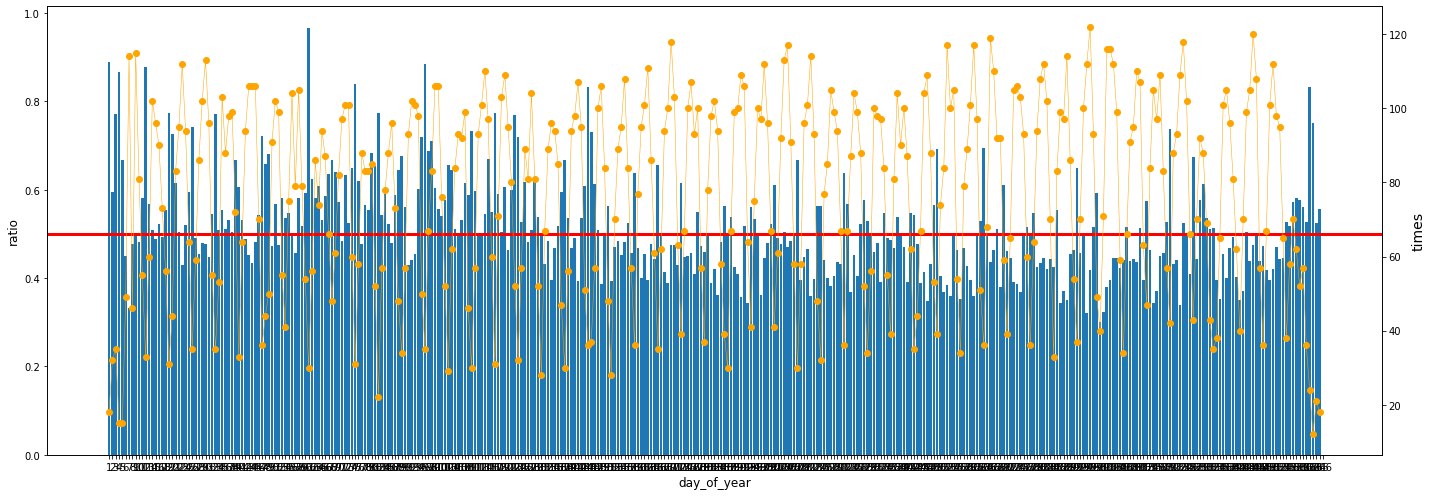

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))

ax.bar(list(zip(*day_of_year_ratio))[0],list(zip(*day_of_year_ratio))[1])
ax.set_xlabel("day_of_year",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(range(1,367,1))
# for i, v in enumerate(list(zip(*day_of_year_ratio))[1]):
#     ax.text(i-0.18, v + 0.01, str(v), color='gray')

ax2 = ax.twinx()
ax2.plot(list(zip(*day_of_year_ratio))[0],list(zip(*day_of_year_list_all))[1], marker = 'o', color='orange', linewidth = 0.5)
ax2.set_ylabel("times",fontsize=14)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
def dof_threshold(list_1,list_2,p):
  dof_index100_list = []
  for (dof, quantity) in list_1:
    if(quantity>=100):
      dof_index100_list.append(dof)

  dof_indexp_list = []
  for (dof, rat) in list_2:
    if p > 0.5:
      if rat>=p:
        dof_indexp_list.append(dof)
    else:
      if rat<=p:
        dof_indexp_list.append(dof)

  day_of_year_segmentation = list(set(dof_indexp_list).intersection(set(dof_index100_list))) 
  return day_of_year_segmentation

In [ ]:
print(day_of_year_ratio[71])
print(day_of_year_list_all[71])

(72, 0.6337)
(72, 101)


In [ ]:
good_day_of_year = dof_threshold(day_of_year_list_all,day_of_year_ratio,0.6)
bad_day_of_year = dof_threshold(day_of_year_list_all,day_of_year_ratio,0.4)
print(good_day_of_year)
print(bad_day_of_year)

[72, 99, 120]
[260, 261, 7, 142, 273, 274, 275, 149, 289, 163, 295, 169, 301, 302, 315, 191, 323, 337, 212, 218, 350, 247, 253, 254]


In [ ]:
def day_of_year_converter(dataframe):
  day_of_year_convert_list = []
  for i in range(dataframe.shape[0]):
    if dataframe['day_of_year'][i] in good_day_of_year:
      day_of_year_convert_list.append('good')
    elif dataframe['day_of_year'][i] in bad_day_of_year:
      day_of_year_convert_list.append('bad')
    else:
      day_of_year_convert_list.append('soso')
  return day_of_year_convert_list

In [ ]:
day_of_year_convert_list_train = day_of_year_converter(X)
day_of_year_convert_list_test = day_of_year_converter(X_test)

X['day_of_year_label'] = day_of_year_convert_list_train
X_test['day_of_year_label'] = day_of_year_convert_list_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87,soso


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252,soso
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304,soso


#### Transform weekday to Weekday_Label
EDA 中發現，原本以為僅六日的 popular ratio較高，結果禮拜五的看起來也滿高的，故分為 **good、soso、bad**

In [ ]:
weekday_list = []
for i in range(X.shape[0]):
    soup = BeautifulSoup(X['Page content'][i], 'lxml')
    date, time, zone = soup.time.string.split(' ')
    date_time = date + " " + time
    date_time_datetime = datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S')
    weekday_list.append(date_time_datetime.weekday())

weekday_list_unique = list(set(weekday_list))
weekday_list_yone_list = list(compress(weekday_list, y==1))
weekday_y_list = list(zip(*(y, weekday_list)))
weekday_list_yone = [(weekday_list_unique[idx], weekday_list_yone_list.count(i)) for (idx, i) in enumerate(weekday_list_unique)]
weekday_list_all = [(weekday_list_unique[idx], weekday_list.count(i)) for (idx, i) in enumerate(weekday_list_unique)]
weekday_ratio = [(i+1,round(weekday_list_yone[i][1] / weekday_list_all[i][1],4)) for i in range(len(weekday_list_unique))]

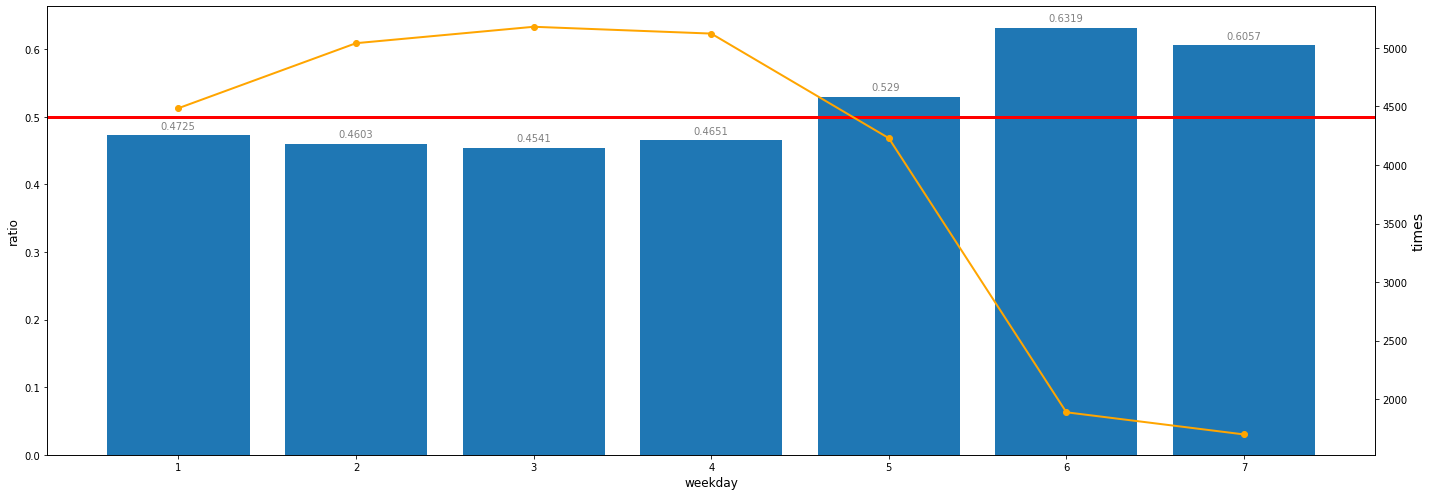

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))

ax.bar(list(zip(*weekday_ratio))[0],list(zip(*weekday_ratio))[1])
ax.set_xlabel("weekday",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(range(12))
for i, v in enumerate(list(zip(*weekday_ratio))[1]):
    ax.text(i+0.9, v + 0.01, str(v), color='gray')

ax2 = ax.twinx()
ax2.plot(list(zip(*weekday_ratio))[0],list(zip(*weekday_list_all))[1], marker = 'o', color = 'orange', linewidth = 2)
ax2.set_ylabel("times",fontsize=14)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
list(zip(*weekday_list_all))[1]

(4485, 5040, 5180, 5122, 4229, 1888, 1699)

In [ ]:
good = [5,6]
soso = [4]
bad = [0,1,2,3]

def weekday_converter(dataframe):
  weekday_convert_list = []
  for i in range(dataframe.shape[0]):
    if dataframe['weekday'][i] in good:
      weekday_convert_list.append(2)
    elif dataframe['weekday'][i] in soso:
      weekday_convert_list.append(1)
    else:
      weekday_convert_list.append(0)
  return weekday_convert_list

In [ ]:
weekday_convert_list_train = weekday_converter(X)
weekday_convert_list_test = weekday_converter(X_test)

X['weekday_label'] = weekday_convert_list_train
X_test['weekday_label'] = weekday_convert_list_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87,soso,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252,soso,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304,soso,0


#### Transform Hour to Hour_Label
EDA 中發現，以小時來看 popular ratio ，有某些時段是較明顯高過其他時段的，因此分為 **good、soso、bad**

In [ ]:
hour_list = []
for i in range(X.shape[0]):
    soup = BeautifulSoup(X['Page content'][i], 'lxml')
    date, time, zone = soup.time.string.split(' ')
    date_time = date + " " + time
    date_time_datetime = datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S')
    hour_list.append(date_time_datetime.hour)

In [ ]:
hour_list_unique = list(set(hour_list))
hour_list_yone_list = list(compress(hour_list, y_new==1))
hour_y_list = list(zip(*(y_new, hour_list)))
hour_list_yone = [(hour_list_unique[idx], hour_list_yone_list.count(i)) for (idx, i) in enumerate(hour_list_unique)]
hour_list_all = [(hour_list_unique[idx], hour_list.count(i)) for (idx, i) in enumerate(hour_list_unique)]
hour_ratio = [(i,round(hour_list_yone[i][1] / hour_list_all[i][1],4)) for i in range(len(hour_list_unique))]

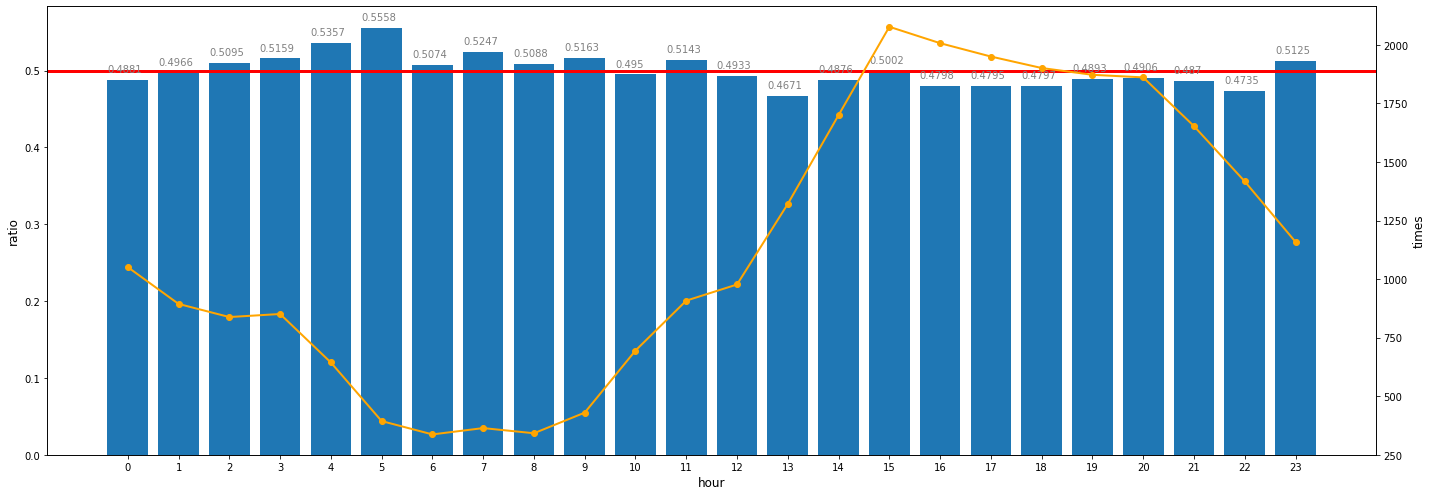

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))

ax.bar(list(zip(*hour_ratio))[0],list(zip(*hour_ratio))[1])
ax.set_xlabel("hour",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(range(24))
for i, v in enumerate(list(zip(*hour_ratio))[1]):
    ax.text(i-0.4, v + 0.01, str(v), color='gray')

ax2 = ax.twinx()
ax2.plot(list(zip(*hour_ratio))[0],list(zip(*hour_list_all))[1], marker = 'o',color='orange', linewidth = 2)
ax2.set_ylabel("times",fontsize=12)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
good = [4, 5, 7]
soso = [1, 2, 3, 6, 8, 9, 10, 11, 12, 15, 20, 23]
bad = [0, 13, 14, 16, 17, 18, 19, 21, 22]

def hour_converter(dataframe):
  hour_convert_list = []
  for i in range(dataframe.shape[0]):
    if dataframe['hour'][i] in good:
      hour_convert_list.append(2)
    elif dataframe['hour'][i] in soso:
      hour_convert_list.append(1)
    else:
      hour_convert_list.append(0)
  return hour_convert_list

In [ ]:
hour_convert_list_train = hour_converter(X)
hour_convert_list_test = hour_converter(X_test)

In [ ]:
X['hour_label'] = hour_convert_list_train
X_test['hour_label'] = hour_convert_list_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87,soso,0,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252,soso,0,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304,soso,0,1


#### Transform month to month_label
EDA 中發現，3、4月的 popular ratio 明顯高過其他月份的，因此分為 **good、soso、bad**

In [ ]:
month_list = []
for i in range(X.shape[0]):
    soup = BeautifulSoup(X['Page content'][i], 'lxml')
    date, time, zone = soup.time.string.split(' ')
    date_time = date + " " + time
    date_time_datetime = datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S')
    month_list.append(date_time_datetime.month)

In [ ]:
month_list_unique = list(set(month_list))
month_list_yone_list = list(compress(month_list, y==1))
month_y_list = list(zip(*(y, month_list)))
month_list_yone = [(month_list_unique[idx], month_list_yone_list.count(i)) for (idx, i) in enumerate(month_list_unique)]
month_list_all = [(month_list_unique[idx], month_list.count(i)) for (idx, i) in enumerate(month_list_unique)]
month_ratio = [(i+1,round(month_list_yone[i][1] / month_list_all[i][1],4)) for i in range(len(month_list_unique))]

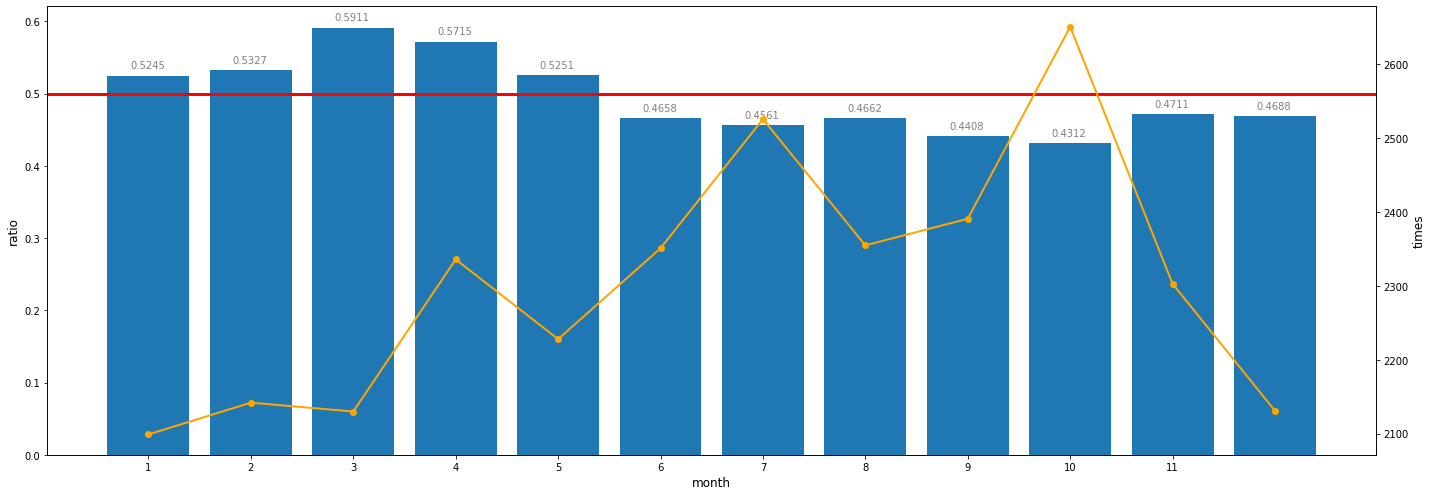

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))

ax.bar(list(zip(*month_ratio))[0],list(zip(*month_ratio))[1])
ax.set_xlabel("month",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(range(12))
for i, v in enumerate(list(zip(*month_ratio))[1]):
    ax.text(i+0.82, v + 0.01, str(v), color='gray')

ax2 = ax.twinx()
ax2.plot(list(zip(*month_ratio))[0],list(zip(*month_list_all))[1], marker = 'o', color='orange', linewidth = 2)
ax2.set_ylabel("times",fontsize=12)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
good = [2, 3]
soso = [0, 1, 4]
bad = [5, 6, 7, 8, 9, 10, 11]

def month_converter(dataframe):
  month_convert_list = []
  for i in range(dataframe.shape[0]):
    if dataframe['month'][i] in good:
      month_convert_list.append(2)
    elif dataframe['month'][i] in soso:
      month_convert_list.append(1)
    else:
      month_convert_list.append(0)
  return month_convert_list

In [ ]:
month_convert_list_train = month_converter(X)
month_convert_list_test = month_converter(X_test)

In [ ]:
X['month_label'] = month_convert_list_train
X_test['month_label'] = month_convert_list_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,0
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87,soso,0,0,2


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252,soso,0,0,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304,soso,0,1,0


#### Transform minute, second to minute_label, second_label, respectively

In [ ]:
sec_list = []
for i in range(X.shape[0]):
    soup = BeautifulSoup(X['Page content'][i], 'lxml')
    date, time, zone = soup.time.string.split(' ')
    date_time = date + " " + time
    date_time_datetime = datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S')
    sec_list.append(date_time_datetime.second)

sec_list_unique = list(set(sec_list))
sec_list_yone_list = list(compress(sec_list, y_new==1))
sec_y_list = list(zip(*(y_new, sec_list)))
sec_list_yone = [(sec_list_unique[idx], sec_list_yone_list.count(i)) for (idx, i) in enumerate(sec_list_unique)]
sec_list_all = [(sec_list_unique[idx], sec_list.count(i)) for (idx, i) in enumerate(sec_list_unique)]
sec_ratio = [(i,round(sec_list_yone[i][1] / sec_list_all[i][1],4)) for i in range(len(sec_list_unique))]

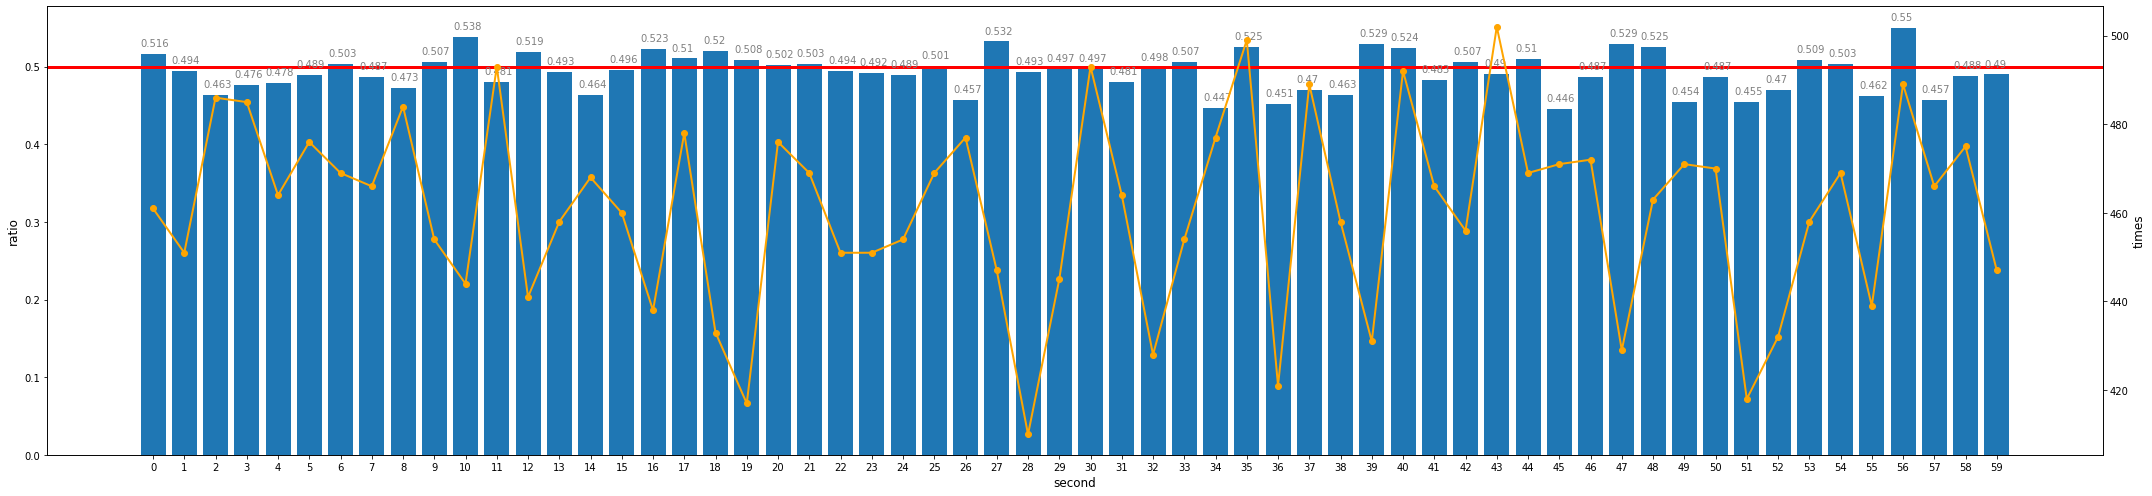

In [ ]:
fig, ax = plt.subplots(figsize=(30,7))

ax.bar(list(zip(*sec_ratio))[0],list(zip(*sec_ratio))[1])
ax.set_xlabel("second",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(range(len(sec_list_unique)))
for i, v in enumerate(list(zip(*sec_ratio))[1]):
    ax.text(i-0.4, v + 0.01, str(round(v,3)), color='gray')

ax2 = ax.twinx()
ax2.plot(list(zip(*sec_ratio))[0],list(zip(*sec_list_all))[1], marker = 'o',color='orange', linewidth = 2)
ax2.set_ylabel("times",fontsize=12)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
min_list = []
for i in range(X.shape[0]):
    soup = BeautifulSoup(X['Page content'][i], 'lxml')
    date, time, zone = soup.time.string.split(' ')
    date_time = date + " " + time
    date_time_datetime = datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S')
    min_list.append(date_time_datetime.minute)

min_list_unique = list(set(min_list))
min_list_yone_list = list(compress(min_list, y_new==1))
min_y_list = list(zip(*(y_new, min_list)))
min_list_yone = [(min_list_unique[idx], min_list_yone_list.count(i)) for (idx, i) in enumerate(min_list_unique)]
min_list_all = [(min_list_unique[idx], min_list.count(i)) for (idx, i) in enumerate(min_list_unique)]
min_ratio = [(i,round(min_list_yone[i][1] / min_list_all[i][1],4)) for i in range(len(min_list_unique))]

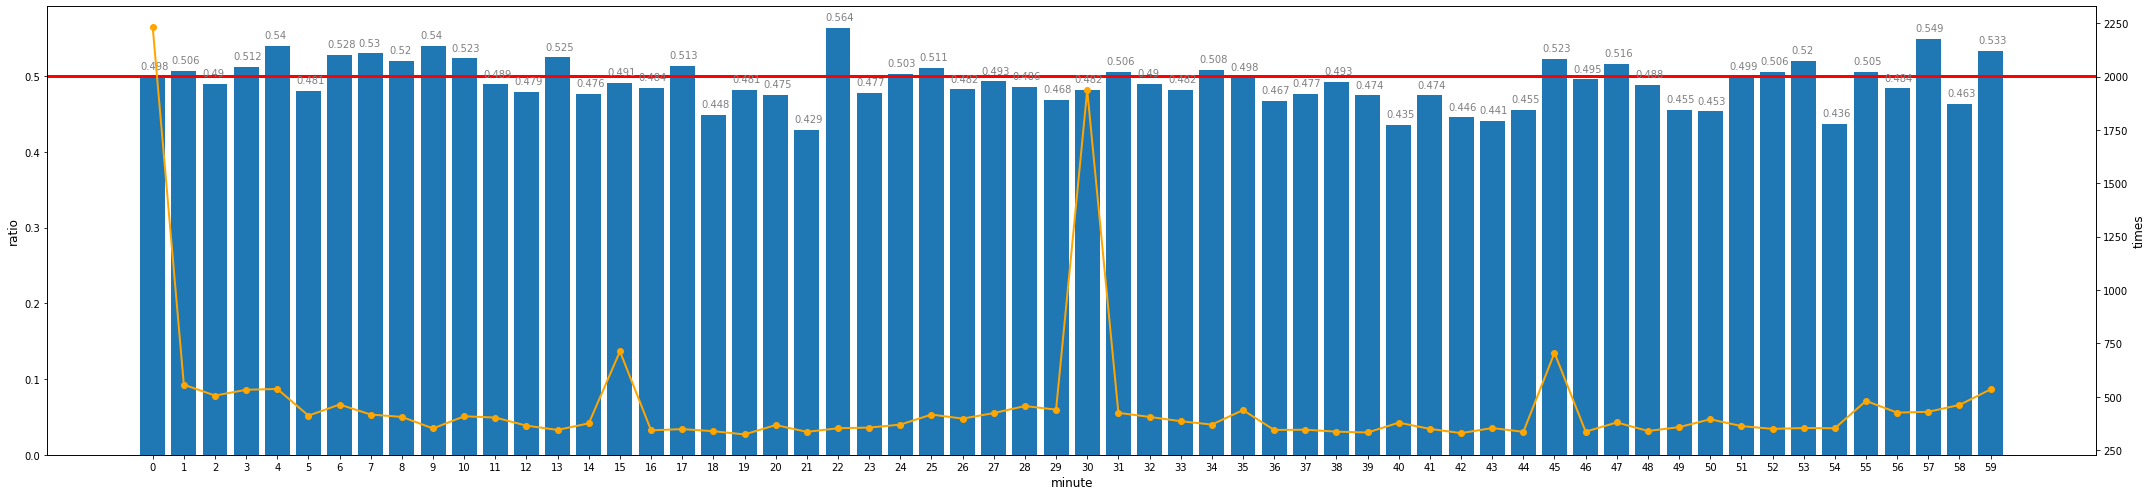

In [ ]:
fig, ax = plt.subplots(figsize=(30,7))

ax.bar(list(zip(*min_ratio))[0],list(zip(*min_ratio))[1])
ax.set_xlabel("minute",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(range(len(min_list_unique)))
for i, v in enumerate(list(zip(*min_ratio))[1]):
    ax.text(i-0.4, v + 0.01, str(round(v,3)), color='gray')

ax2 = ax.twinx()
ax2.plot(list(zip(*min_ratio))[0],list(zip(*min_list_all))[1], marker = 'o',color='orange', linewidth = 2)
ax2.set_ylabel("times",fontsize=12)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
def threshold_to_index(ratio_list,p1,p2):
    good = []
    soso = []
    bad = []
    for idx, ratio in ratio_list:
        if ratio >= p1:
            good.append(idx)
        elif ratio < p1 and ratio > p2:
            soso.append(idx)
        else:
            bad.append(idx)
    return(good, soso, bad)

good_sec, soso_sec, bad_sec = threshold_to_index(sec_ratio,0.525,0.475)
good_min, soso_min, bad_min = threshold_to_index(min_ratio,0.530,0.470)

In [ ]:
def min_sec_converter(dataframe,good_list,soso_list,bad_list,string):
  convert_list = []
  for i in range(dataframe.shape[0]):
    if dataframe[string][i] in good_list:
      convert_list.append(2)
    elif dataframe[string][i] in soso_list:
      convert_list.append(1)
    else:
      convert_list.append(0)
  return convert_list

In [ ]:
minute_convert_list_train = min_sec_converter(X,good_min, soso_min, bad_min,'minute' )
minute_convert_list_test = min_sec_converter(X_test,good_min, soso_min, bad_min,'minute' )
second_convert_list_train = min_sec_converter(X,good_sec, soso_sec, bad_sec,'second' )
second_convert_list_test = min_sec_converter(X_test,good_sec, soso_sec, bad_sec,'second' )

In [ ]:
X['minute_label'] = minute_convert_list_train
X_test['minute_label'] = minute_convert_list_test
X['second_label'] = second_convert_list_train
X_test['second_label'] = second_convert_list_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,0,2,1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87,soso,0,0,2,0,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252,soso,0,0,0,1,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304,soso,0,1,0,1,0


#### Find good combination of month and weekday
在EDA 圖中能發現每週的發文數、popular ratio 具明顯相似趨勢
* 平日發文數較多
* 平日的 popular ratio 較低
因此分為 good month week、bad month week

In [ ]:
month_weekday_list_unique = list(set(X['month_weekday']))
month_weekday_yone_list = list(compress(X['month_weekday'], y==1))
month_weekday_y_list = list(zip(*(y_new, X['month_weekday'])))
month_weekday_list_yone = [(month_weekday_list_unique[idx], month_weekday_yone_list.count(i)) for (idx, i) in enumerate(month_weekday_list_unique)]
month_weekday_list_all = [(month_weekday_list_unique[idx], list(X['month_weekday']).count(i)) for (idx, i) in enumerate(month_weekday_list_unique)]
month_weekday_ratio = [(month_weekday_list_unique[i],round(month_weekday_list_yone[i][1] / month_weekday_list_all[i][1],4)) for i in range(len(month_weekday_list_unique))]

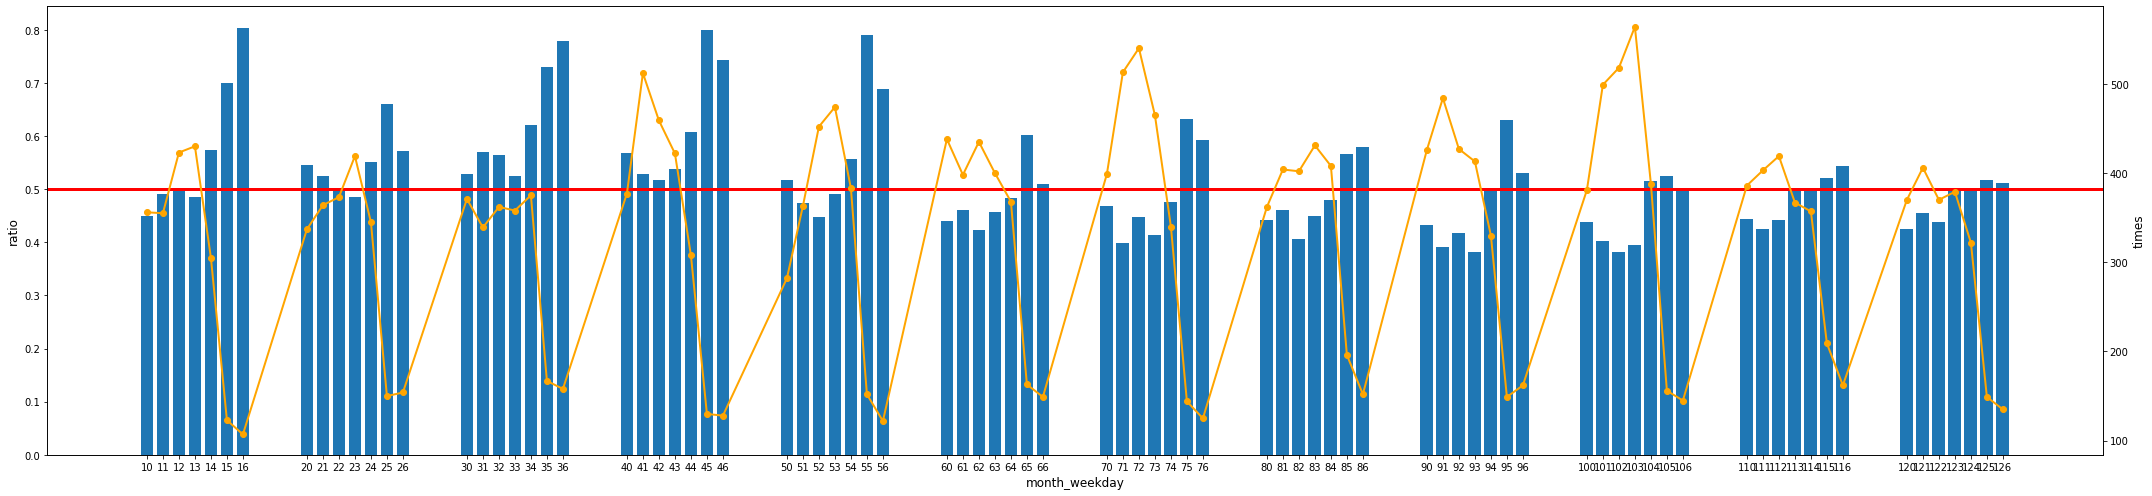

In [ ]:
fig, ax = plt.subplots(figsize=(30,7))

ax.bar(list(zip(*month_weekday_ratio))[0],list(zip(*month_weekday_ratio))[1])
ax.set_xlabel("month_weekday",fontsize=12)
ax.set_ylabel("ratio",fontsize=12)
ax.set_xticks(list(zip(*month_weekday_ratio))[0])

ax2 = ax.twinx()
ax2.plot(list(zip(*month_weekday_ratio))[0],list(zip(*month_weekday_list_all))[1], marker = 'o', color='orange', linewidth = 2)
ax2.set_ylabel("times",fontsize=12)
plt.tight_layout()
ax.axhline(y=0.5,linewidth=3, color='r')
plt.show()

In [ ]:
def month_weekday_threshold(list_1,list_2,p):
    month_weekday_list_q = []
    for (mw, quantity) in list_1:
        if(quantity>=np.mean(list(zip(*list_1))[1])):
            month_weekday_list_q.append(mw)
    month_weekday_indexp_list = []
    for (mw, rat) in list_2:
        if p > 0.5:
            if rat>=p:
                month_weekday_indexp_list.append(mw)
        else:
            if rat<=p:
                month_weekday_indexp_list.append(mw)

    month_weekday_segmentation = list(set(month_weekday_indexp_list).intersection(set(month_weekday_list_q))) 
    return month_weekday_segmentation

good_mw = month_weekday_threshold(month_weekday_list_all,month_weekday_ratio,0.55)
bad_mw = month_weekday_threshold(month_weekday_list_all,month_weekday_ratio,0.45)

print(good_mw)
print(bad_mw)

[32, 34, 40, 54, 24, 31]
[10, 52, 60, 62, 71, 72, 73, 80, 82, 90, 91, 92, 93, 100, 101, 102, 103, 110, 111, 112, 120, 122]


In [ ]:
def month_weekday_converter(dataframe):
  mw_list = []
  for mw in dataframe['month_weekday']:
      if mw in good_mw:
          mw_list.append('good')
      elif mw in bad_mw:
          mw_list.append('bad')
      else:
          mw_list.append('soso')
  return mw_list

In [ ]:
mw_train = month_weekday_converter(X)
mw_test = month_weekday_converter(X_test)

In [ ]:
X['month_weekday_label'] = mw_train
X_test['month_weekday_label'] = mw_test

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",1.0,0.0,1.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,0,2,1,clara moskowitz,soso,bad
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,good_article_class,8,2,87,soso,0,0,2,0,0,christina warren,soso,soso


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,bad_article_class,22,1,252,soso,0,0,0,1,0,sam laird,soso,bad
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,good_article_class,7,3,304,soso,0,1,0,1,0,stan schroeder,soso,bad


In [ ]:
# just for checking
# X['month_weekday'][X['month_weekday_label'] == 'good']

#### Transform month, day, weekday

In [ ]:
X['month_squared'] = (X['month']-5.5)**2
X['month_centered'] = (X['month']-5.5)
X['day_squared'] = (X['day']-15)**2
X['day_centered'] = (X['day']-15)
X['weekday_squared'] = (X['weekday']-3)**2
X['weekday_centered'] = (X['weekday']-3)
X_test['month_squared'] = (X_test['month']-5.5)**2
X_test['month_centered'] = (X_test['month']-5.5)
X_test['day_squared'] = (X_test['day']-15)**2
X_test['day_centered'] = (X_test['day']-15)
X_test['weekday_squared'] = (X_test['weekday']-3)**2
X_test['weekday_centered'] = (X_test['weekday']-3)

display(X.head(2))
display(X_test.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",0.0,0.0,0.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,0,2,1,clara moskowitz,soso,bad,0.25,0.5,16,4,1,-1
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,soso_article_class,8,2,87,soso,0,0,2,0,0,christina warren,soso,soso,6.25,-2.5,169,13,0,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,minute_label,second_label,author,author_label,month_weekday_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,soso_article_class,22,1,252,soso,0,0,0,1,0,sam laird,soso,bad,12.25,3.5,36,-6,9,-3
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,soso_article_class,7,3,304,soso,0,1,0,1,0,stan schroeder,soso,bad,20.25,4.5,256,16,0,0


### **TF-IDF**
將前面從文章中萃取出的title和foot topic，分別計算裡文字的TF-IDF。為了避免取出太多文字，設定 max_features = 100。

In [ ]:
df_trn = pd.read_csv('./data/train.csv')
df_tst = pd.read_csv('./data/test.csv')

import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop = stopwords.words('english')

def preprocessor(text):
   
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

from sklearn.feature_extraction.text import TfidfVectorizer

def getFeature_TFIDF(trn, tst, top):
    tfidf_trn = TfidfVectorizer(ngram_range=(1,2), max_features=top)
    tfidf_trn.fit(trn)
    
    tfidf_tst = TfidfVectorizer(vocabulary=tfidf_trn.vocabulary_)
    tfidf_tst.fit(tst)
    
    df_trn_tfidf = pd.DataFrame(tfidf_trn.transform(trn).toarray(), columns=tfidf_trn.get_feature_names())
    df_tst_tfidf = pd.DataFrame(tfidf_tst.transform(tst).toarray(), columns=tfidf_tst.get_feature_names())
    return df_trn_tfidf, df_tst_tfidf

feature_title_trn, feature_title_tst = getFeature_TFIDF(title_trn, title_tst, top=100)
feature_foot_topic_trn, feature_foot_topic_tst = getFeature_TFIDF(foot_topic_trn, foot_topic_tst, top=100)

title_colname = []
topic_colname = []
for i in range(feature_title_trn.shape[1]):
    title_colname.append("title_"+feature_title_trn.columns[i])
    topic_colname.append("topic_"+feature_foot_topic_trn.columns[i])

feature_title_trn = pd.DataFrame(feature_title_trn.values, columns = title_colname)
feature_title_tst = pd.DataFrame(feature_title_tst.values, columns = title_colname)
feature_foot_topic_trn = pd.DataFrame(feature_foot_topic_trn.values, columns = topic_colname)
feature_foot_topic_tst = pd.DataFrame(feature_foot_topic_tst.values, columns = topic_colname)


### One Hot Encoding Transformation

In [ ]:
ohe_needed_features = ['length_of_character','length_of_article','day_partition','article_class','day_of_year_label','author_label','month_weekday_label']

X_combine = X_combine.join(pd.get_dummies(X_combine[ohe_needed_features]))
X_combine = X_combine.join(pd.get_dummies(X_combine['year']))
X_test_combine = X_test_combine.join(pd.get_dummies(X_test_combine[ohe_needed_features]))
X_test_combine = X_test_combine.join(pd.get_dummies(X_test_combine['year']))
display(X_combine.head(2))
display(X_test_combine.head(2))

,Id,Popularity,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,...,day_centered,weekday_squared,weekday_centered,top10_holidays,top5_holidays,NewYear,Easter,Independence,Christmas,Thanksgiving,ten_freq_author,hundred_freq_author,thousand_freq_author,five_hundred_freq_author,length_of_character_few,length_of_character_many,length_of_character_some,length_of_article_long,length_of_article_medium,length_of_article_short,day_partition_afternoon,day_partition_evening,day_partition_midnight,day_partition_morning,article_class_,article_class_bad_article_class,article_class_good_article_class,article_class_soso_article_class,day_of_year_label_bad,day_of_year_label_good,day_of_year_label_soso,author_label_bad,author_label_good,author_label_soso,month_weekday_label_bad,month_weekday_label_good,month_weekday_label_soso,2013,2014,2015
0,0,-1,"<html><head><div class=""article-info""> <span c...",60,8,0,0,1,7,"[Asteroid, Asteroids, challenge, Earth, Space,...",0.0,0.0,0.0,22,14,0,2013-06-19,15:04:30,2013,6,19,2,15,4,30,62,afternoon,3773,600,many,long,0,1,bad_article_class,5,1,170,soso,0,1,...,4,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0
1,1,1,"<html><head><div class=""article-info""><span cl...",74,12,0,0,1,8,"[Apps and Software, Google, open source, opn p...",0.0,0.0,0.0,18,9,0,2013-03-28,17:40:55,2013,3,28,3,17,40,55,33,afternoon,2073,337,some,medium,0,1,soso_article_class,8,2,87,soso,0,0,...,13,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0


,Id,Page content,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,topic,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,date_list,time_list,year,month,day,weekday,hour,minute,second,month_weekday,day_partition,article_character_no,article_string_no,length_of_character,length_of_article,is_weekend,is_workday,article_class,par_count,image_count,day_of_year,day_of_year_label,weekday_label,hour_label,month_label,...,day_squared,day_centered,weekday_squared,weekday_centered,top10_holidays,top5_holidays,NewYear,Easter,Independence,Christmas,Thanksgiving,ten_freq_author,hundred_freq_author,thousand_freq_author,five_hundred_freq_author,length_of_character_few,length_of_character_many,length_of_character_some,length_of_article_long,length_of_article_medium,length_of_article_short,day_partition_afternoon,day_partition_evening,day_partition_midnight,day_partition_morning,article_class_,article_class_bad_article_class,article_class_good_article_class,article_class_soso_article_class,day_of_year_label_bad,day_of_year_label_good,day_of_year_label_soso,author_label_bad,author_label_good,author_label_soso,month_weekday_label_bad,month_weekday_label_good,month_weekday_label_soso,2013,2014
0,27643,"<html><head><div class=""article-info""><span cl...",74,11,0,0,0,5,"[Entertainment, Music, One Direction, soccer, ...",0.0,0.0,0.0,30,24,9,2013-09-09,19:47:02,2013,9,9,0,19,47,2,90,evening,3837,552,many,medium,0,1,soso_article_class,22,1,252,soso,0,0,0,...,36,-6,9,-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0
1,27644,"<html><head><div class=""article-info""><span cl...",36,6,0,0,0,6,"[Gadgets, glass, Google, Google Glass, Google ...",0.0,0.0,0.0,13,6,0,2013-10-31,09:25:02,2013,10,31,3,9,25,2,103,morning,963,161,few,short,0,1,soso_article_class,7,3,304,soso,0,1,0,...,256,16,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0


## Output the preprocessed dataset, X_combine and X_test_combine

In [ ]:
def feature_removed(dataframe,list_):
  feature_used = dataframe.columns
  feature_used = list(feature_used)
  for fea in list_:
    feature_used.remove(fea)
  return feature_used

# Output the pre-processed data

from google.colab import  drive
# drive.mount('/drive')

feature_removed_train = ['Page content', 'date_list', 'time_list', 2015,'year','day_partition','length_of_character','length_of_article','article_class','author'] # no year = 2015 in testing set

feature_used_train = feature_removed(X_combine,feature_removed_train)
print("Feature used Train:", len(feature_used_train))

X_combine[feature_used_train].to_csv('/drive/My Drive/Competition1_Text_Mining/X_TRAIN.csv', index=False)

feature_removed_test = ['Page content','date_list', 'time_list','year','day_partition','length_of_character','length_of_article','article_class','author'] 

feature_used_test = feature_removed(X_test_combine,feature_removed_test)
print("Feature used Test:", len(feature_used_test))

X_test_combine[feature_used_test].to_csv('/drive/My Drive/Competition1_Text_Mining/X_TEST.csv', index=False)

Feature used Train: 79
Feature used Test: 78


# ***Feature Selection***

原有78個變數，重複<b>建模並以 Importance Scores為依據刪減變數</b>得到以下重要變數，其中Importance Scores來自tree-based models。
以下的結果只是其中一次的嘗試，我們in general表現好的模型只用了28個變數，而最好的模型則多考慮了tf-idf所造出的變數

# ***Model Building and Parameter Tuning***

### Removed Unused Features

In [ ]:
feature_used = X_combine.columns
feature_used = list(feature_used)

#  'count_href_link', 'count_href_total','minute','second','article_character_no','article_string_no',
# 'length_of_character_many','length_of_character_few','length_of_character_some','title_tag_totalcharacter_count',
# 'day_partition_morning','day_partition_midnight','day_partition_evening','day_partition_afternoon',


# 'punctuation_count_comma',


feature_removed_fea = ['Id','Popularity','Page content', 2015, 'year','day_partition','date_list', 'time_list','article_class',
                       'length_of_character','length_of_article',
                      'day_of_year_label',
'author_label','month_weekday_label',
'author','topic',
 'month',
'day',
'weekday',
'top10_holidays',
 'top5_holidays',
 'NewYear',
 'Easter',
 'Independence',
 'Christmas',
 'Thanksgiving',
 'ten_freq_author',
 'hundred_freq_author',
 'thousand_freq_author',
 'five_hundred_freq_author',
 2014,
 'month_label',
  'minute_label',
 'second_label'
] # no year = 2015 in testing set

def feature_removed(list_):
  for fea in list_:
    feature_used.remove(fea)
  return feature_used
  
feature_used = feature_removed(feature_removed_fea)

print("Feature used:", len(feature_used))

feature_used
# feature_used.remove('date_list')
# feature_used.remove('time_list')
# feature_used.remove('count_href_link')
# feature_used.remove('count_href_total')

Feature used: 55


['title_tag_totalcharacter_count',
 'title_tag_totalstring_count',
 'contain_digit',
 'punctuation_count_comma',
 'punctuation_count_ex_que_col',
 'topic_len',
 'good_topic_score',
 'bad_topic_score',
 'total_topic_score',
 'count_href_total',
 'count_href_link',
 'count_href_twitter',
 'hour',
 'minute',
 'second',
 'month_weekday',
 'article_character_no',
 'article_string_no',
 'is_weekend',
 'is_workday',
 'par_count',
 'image_count',
 'day_of_year',
 'weekday_label',
 'hour_label',
 'month_squared',
 'month_centered',
 'day_squared',
 'day_centered',
 'weekday_squared',
 'weekday_centered',
 'length_of_character_few',
 'length_of_character_many',
 'length_of_character_some',
 'length_of_article_long',
 'length_of_article_medium',
 'length_of_article_short',
 'day_partition_afternoon',
 'day_partition_evening',
 'day_partition_midnight',
 'day_partition_morning',
 'article_class_',
 'article_class_bad_article_class',
 'article_class_good_article_class',
 'article_class_soso_article

In [ ]:
display(X_combine[feature_used].head(2))
display(X_test_combine[feature_used].head(2))
print(X_combine[feature_used].shape)
print(X_test_combine[feature_used].shape)

,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,hour,minute,second,month_weekday,article_character_no,article_string_no,is_weekend,is_workday,par_count,image_count,day_of_year,weekday_label,hour_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered,length_of_character_few,length_of_character_many,length_of_character_some,length_of_article_long,length_of_article_medium,length_of_article_short,day_partition_afternoon,day_partition_evening,day_partition_midnight,day_partition_morning,article_class_,article_class_bad_article_class,article_class_good_article_class,article_class_soso_article_class,day_of_year_label_bad,day_of_year_label_good,day_of_year_label_soso,author_label_bad,author_label_good,author_label_soso,month_weekday_label_bad,month_weekday_label_good,month_weekday_label_soso,2013
0,60,8,0,0,1,7,0.0,0.0,0.0,22,14,0,15,4,30,62,3773,600,0,1,5,1,170,0,1,0.25,0.5,16,4,1,-1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1
1,74,12,0,0,1,8,0.0,0.0,0.0,18,9,0,17,40,55,33,2073,337,0,1,8,2,87,0,0,6.25,-2.5,169,13,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1


,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,hour,minute,second,month_weekday,article_character_no,article_string_no,is_weekend,is_workday,par_count,image_count,day_of_year,weekday_label,hour_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered,length_of_character_few,length_of_character_many,length_of_character_some,length_of_article_long,length_of_article_medium,length_of_article_short,day_partition_afternoon,day_partition_evening,day_partition_midnight,day_partition_morning,article_class_,article_class_bad_article_class,article_class_good_article_class,article_class_soso_article_class,day_of_year_label_bad,day_of_year_label_good,day_of_year_label_soso,author_label_bad,author_label_good,author_label_soso,month_weekday_label_bad,month_weekday_label_good,month_weekday_label_soso,2013
0,74,11,0,0,0,5,0.0,0.0,0.0,30,24,9,19,47,2,90,3837,552,0,1,22,1,252,0,0,12.25,3.5,36,-6,9,-3,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1
1,36,6,0,0,0,6,0.0,0.0,0.0,13,6,0,9,25,2,103,963,161,0,1,7,3,304,0,1,20.25,4.5,256,16,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1


(27643, 55)
(11847, 55)


以下可以直接讀上方output出來的資料，不需要再重跑EDA及feature engineering的code

In [ ]:
# downloaded = drive.CreateFile({'id':"1-0nCIljDf67f2y3uZ0AbZiK2Nxlp-zDE"})   # replace the id with id of file you want to access
# downloaded.GetContentFile("X_TRAIN.csv") 
# X_combine = pd.read_csv("X_TRAIN.csv")
# downloaded = drive.CreateFile({'id':"1hQ_dRRzAhcksEJUYsWWR8-HospeiVDrW"})   # replace the id with id of file you want to access
# downloaded.GetContentFile("X_TEST.csv") 
# X_test_combine = pd.read_csv("X_TEST.csv")

# feature_used = X_combine.columns
# feature_used = list(feature_used)

# #  'count_href_link', 'count_href_total','minute','second','article_character_no','article_string_no',
# # 'length_of_character_many','length_of_character_few','length_of_character_some','title_tag_totalcharacter_count',
# # 'day_partition_morning','day_partition_midnight','day_partition_evening','day_partition_afternoon',

# #Page content, 2015, 'year','day_partition','date_list', 'time_list',,'article_class','length_of_character','length_of_article',

# feature_removed_fea = ['Id','Popularity',
#                        'length_of_character_some', 'second',
#                        'length_of_article_medium','length_of_character_few',
# 'length_of_article_short','ten_freq_author','hundred_freq_author', 'top5_holidays',
#  'NewYear',
#  'Easter',
#  'Independence',
#  'Christmas',
#  'Thanksgiving',
#  'top10_holidays',
#  'thousand_freq_author',
#  'five_hundred_freq_author',
#  'day_partition_afternoon',
#  'day_partition_evening',
#  'day_partition_morning'] # no year = 2015 in testing set

# def feature_removed(list_):
#   for fea in list_:
#     feature_used.remove(fea)
#   return feature_used
  
# feature_used = feature_removed(feature_removed_fea)

# print("Feature used:", len(feature_used))

# feature_used

In [ ]:
X_combine[feature_used].head(2)

,title_tag_totalcharacter_count,title_tag_totalstring_count,contain_digit,punctuation_count_comma,punctuation_count_ex_que_col,topic_len,good_topic_score,bad_topic_score,total_topic_score,count_href_total,count_href_link,count_href_twitter,hour,minute,second,month_weekday,article_character_no,article_string_no,is_weekend,is_workday,par_count,image_count,day_of_year,weekday_label,hour_label,month_label,minute_label,second_label,month_squared,month_centered,day_squared,day_centered,weekday_squared,weekday_centered,length_of_character_few,length_of_character_many,length_of_character_some,length_of_article_long,length_of_article_medium,length_of_article_short,day_partition_afternoon,day_partition_evening,day_partition_midnight,day_partition_morning,article_class_,article_class_bad_article_class,article_class_good_article_class,article_class_soso_article_class,day_of_year_label_bad,day_of_year_label_good,day_of_year_label_soso,author_label_bad,author_label_good,author_label_soso,month_weekday_label_bad,month_weekday_label_good,month_weekday_label_soso,2013
0,60,8,0,0,1,7,0.0,0.0,0.0,22,14,0,15,4,30,62,3773,600,0,1,5,1,170,0,1,0,2,1,0.25,0.5,16,4,1,-1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1
1,74,12,0,0,1,8,0.0,0.0,0.0,18,9,0,17,40,55,33,2073,337,0,1,8,2,87,0,0,2,0,0,6.25,-2.5,169,13,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1


### Nested CV with Scikit-Learn XGBoost

* Nested CV主要目的在於確保我們從GridSearch中找出的最佳模型沒有overfitting；之所以可以達成此效果是源於inner CV的的AUC傾向於高估新資料prediction的AUC，因為我們是透過inner中的每次hold out的fold(validation set)來做調整參數，故再將此調出的模型fit回inner中的holdout set效果(AUC)必定好。
* outer CV的好處即為我們可以提前hold out 一組testing set，而這組testing set將不會在調整參數時被看到，故可以將其視為一筆未被見過的新資料，若validation的AUC大幅上升，而testing's卻沒有顯著上升甚至下降，則可以知道我們overfitting了。
* 事實上,outer CV的AUC雖為比inner CV的AUC更具代表性也是我們最能夠用來measure模型好壞的方式，但這也不代表著真實配置到新資料時AUC一定會跟outer CV的AUC很接近，原因如下：
  1. 若outer CV的平均AUC高估新資料的AUC(Leaderboard)可能原因為我們做EDA以及feature englineering時偷看到了outer CV hold out 的testing set了。事實上這是個<b>必要之惡</b>，我們當然可以早在EDA前就hold out一組testing set，但這也代表了我們只能based on更少的資料去做EDA以及feature engineering，這樣可能造成資料量不足無法捕捉到online article真正有意義的變數及pattern。
  2. 若outer CV的平均AUC低估新資料的AUC(Leaderboard)，則我們可以去查看n(5-fold即為5)個holdout testing分別的表現，這很有可能是因為每個fold因為分配皆不同造成的noise，而新資料的AUC也會有自己的分配，故上下起伏是很正常的，這當然也可以是outer CV的平均AUC高估新資料的AUC(Leaderboard)的可能原因。


我們以下的Nested CV以5-fold outer CV及5-fold inner CV作為模型評估。
1. inner CV的平均AUC最高可以達到0.62左右，但經過多次嘗試，0.6-0.61間有最好的表現in terms of leaderboard result.
2. outer CV的平均AUC最高可以達到0.587左右，而0.57-0.58間時有最好的表現in terms of leaderboard result.

In [ ]:
X_combine_fea = X_combine[feature_used_rfe]
X_combine_fea_array = np.array(X_combine_fea)

In [ ]:
outer_cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
inner_cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)

inner_scores = []
outer_scores = []

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_combine_fea_array,y_new)):
  print('[Outer fold %d/5]' % (i + 1)) 
  X_Combine_train_cv, X_Combine_test_cv = X_combine_fea_array[train_idx], X_combine_fea_array[test_idx]
  y_Combine_train_cv, y_Combine_test_cv = y_new[train_idx], y_new[test_idx]

  xgboost = GradientBoostingClassifier()

  param_grid = {"max_depth": [6],
              "n_estimators" : [200],
              "learning_rate" : [0.01],
              "max_features" : [8],
              "min_samples_leaf" : [100],
              "subsample" : [0.7],
              "min_samples_split":[0.003]
              }

  GridSearch_XG_Nested = GridSearchCV(xgboost, scoring = 'roc_auc', verbose = 2, return_train_score = True, param_grid = param_grid, cv = inner_cv, n_jobs = -1)
  GridSearch_XG_Nested.fit(X_Combine_train_cv,y_Combine_train_cv)
  best_xg = GridSearch_XG_Nested.best_estimator_
  inner_scores.append(GridSearch_XG_Nested.best_score_)
  print('Train auc: %.5f' % inner_scores[i])
  print('Best Parameter:{}'.format(GridSearch_XG_Nested.best_params_))
  outer_scores.append(best_xg.score(X_Combine_test_cv, y_Combine_test_cv))

  print('Test auc: %.5f' % (outer_scores[i]))
  
print('\ninner_scores:',np.round(inner_scores,4))
print('outer_scores:',np.round(outer_scores,4))
print('\nTest auc average: %.5f (5x5 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


Train auc: 0.59567
Best Parameter:{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 0.003, 'n_estimators': 200, 'subsample': 0.7}
Test auc: 0.57750
[Outer fold 2/5]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


Train auc: 0.59507
Best Parameter:{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 0.003, 'n_estimators': 200, 'subsample': 0.7}
Test auc: 0.57949
[Outer fold 3/5]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


Train auc: 0.59725
Best Parameter:{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 0.003, 'n_estimators': 200, 'subsample': 0.7}
Test auc: 0.56574
[Outer fold 4/5]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


Train auc: 0.59583
Best Parameter:{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 0.003, 'n_estimators': 200, 'subsample': 0.7}
Test auc: 0.57652
[Outer fold 5/5]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


Train auc: 0.59964
Best Parameter:{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 0.003, 'n_estimators': 200, 'subsample': 0.7}
Test auc: 0.55897

inner_scores: [0.5957 0.5951 0.5973 0.5958 0.5996]
outer_scores: [0.5775 0.5795 0.5657 0.5765 0.559 ]

Test auc average: 0.57165 (5x5 nested CV)


In [ ]:
print('inner_scores:',np.round(inner_scores,4))
print('outer_scores:',np.round(outer_scores,4))

outer_scores: [0.5902 0.5889 0.5808 0.5944 0.5801]


In [ ]:
np.var(np.round(outer_scores,4)) ** 0.5

0.00793463294677201

### GridSearch with Scikit-Learn XGBOOST

步驟：
1. 先找出一組不錯的參數作為Recursive Feature Elimination(RFE)的模型依據
2. 應用RFE選出30個重要變數
3. 使用GridSearch先找出最佳learning rate和n_estimator，因兩者互相牽制
4. 再依據3.找出的learning rate和n_estimator使用一次GridSearch來尋找其他參數的最佳組合

In [ ]:
# Model Building - XGBoost (try X_comb)

param_grid = {"max_depth": [4,5,6],
              "learning_rate" : [0.01, 0.005, 0.001,],
              "max_features" : [4,6,8],
              "min_samples_leaf" : [leaf for leaf in range(100,150,50)],
              "subsample" : [0.7],
              "min_samples_split":[slt for slt in np.arange(0.001,0.005,0.002)]
              }

xgboost = GradientBoostingClassifier()

GridSearch_XG = GridSearchCV(xgboost, scoring = 'roc_auc', verbose = 2, return_train_score = True, param_grid = param_grid, cv = 3, n_jobs = -1)
GridSearch_XG.fit(X_combine[feature_used],y_new)

best_xg_first_step = GridSearch_XG.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.3min finished


In [ ]:
# create a base classifier used to evaluate a subset of attributes
model = best_xg_first_step
# create the RFE model and select 30 attributes
rfe = RFE(model, 30)
rfe = rfe.fit(X_combine[feature_used], y_new)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

important_feature_rfe = [idx for (idx, value) in enumerate(list(rfe.ranking_)) if list(rfe.ranking_)[idx] == 1]
feature_used_rfe = [feature_used[idx] for idx in important_feature_rfe]

[ True  True  True False False False False False False  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True False False False False False
 False False False False False False  True False False  True False  True
  True  True False  True False False  True]
[ 1  1  1 13 15  2  9 11  4  1  1 12  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  7  1 21 22 26 14 25 23 17 18 20 10 24  1  5 19  1 16  1
  1  1  6  1  8  3  1]


In [ ]:
# Model Building - XGBoost (try X_comb)

param_grid = {"n_estimators" : [200,400,600],
              "learning_rate" : [0.1,0.01,0.001]
              }

xgboost = GradientBoostingClassifier()

GridSearch_XG = GridSearchCV(xgboost, scoring = 'roc_auc', verbose = 2, return_train_score = True, param_grid = param_grid, cv = 3, n_jobs = -1)

GridSearch_XG.fit(X_combine[feature_used_rfe],y_new)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  6.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [ ]:
print("Best parameters:{}".format(GridSearch_XG.best_params_))
print("Best score on train set:{:.4f}".format(GridSearch_XG.best_score_))

Best parameters:{'learning_rate': 0.01, 'n_estimators': 200}
Best score on train set:0.5928


In [ ]:
# Model Building - XGBoost (try X_comb)

param_grid = {"max_depth": [3,4,5,6],
              "n_estimators" : [200],
              "learning_rate" : [0.01],
              "max_features" : [3,4,6,8],
              "min_samples_leaf" : [leaf for leaf in range(50,201,50)],
              "subsample" : [0.7],
              "min_samples_split":[slt for slt in np.arange(0.001,0.007,0.002)]
              }

xgboost = GradientBoostingClassifier()

GridSearch_XG = GridSearchCV(xgboost, scoring = 'roc_auc', verbose = 2, return_train_score = True, param_grid = param_grid, cv = 3, n_jobs = -1)

GridSearch_XG.fit(X_combine[feature_used_rfe],y_new)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 23.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [ ]:
# print the result of gridsearch

print("Best parameters:{}".format(GridSearch_XG.best_params_))
print("Best score on train set:{:.4f}".format(GridSearch_XG.best_score_))

Best parameters:{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 0.003, 'n_estimators': 200, 'subsample': 0.7}
Best score on train set:0.5963


In [ ]:
y_test_pred = pd.DataFrame(pd.DataFrame(GridSearch_XG.best_estimator_.predict_proba(X_test_combine[feature_used_rfe]))[1])
y_test_pred.columns = ['Popularity']
y_test_pred['Id'] = [id for id in range(27643,39490,1)]
y_test_pred_form = ['Id','Popularity']
y_test_pred = y_test_pred[y_test_pred_form]

In [ ]:
y_test_pred

,Id,Popularity
0,27643,0.445094
1,27644,0.433603
2,27645,0.464624
3,27646,0.557781
4,27647,0.482861
...,...,...
11842,39485,0.685956
11843,39486,0.497893
11844,39487,0.502242
11845,39488,0.445750


In [ ]:
from google.colab import  drive
# drive.mount('/drive')

y_test_pred.to_csv('/drive/My Drive/Competition1_Text_Mining/y_predok.csv', index=False)

* 畫出testing set prediction的分配作為private leadearboard選擇結果的參考

(array([   8.,   77.,  225.,  366.,  640., 1704., 1724., 1940., 1538.,
        1057.,  814.,  625.,  303.,  179.,  129.,  177.,  162.,   85.,
          73.,   21.]),
 array([0.30546911, 0.32882416, 0.3521792 , 0.37553425, 0.3988893 ,
        0.42224435, 0.44559939, 0.46895444, 0.49230949, 0.51566453,
        0.53901958, 0.56237463, 0.58572967, 0.60908472, 0.63243977,
        0.65579482, 0.67914986, 0.70250491, 0.72585996, 0.749215  ,
        0.77257005]),
 <a list of 20 Patch objects>)

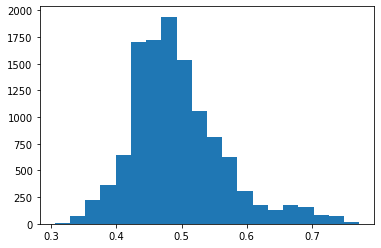

In [ ]:
plt.hist(y_test_pred['Popularity'], bins = 20)

In [ ]:
y_test_pred[]

,Id,Popularity
0,27643,0.445094
1,27644,0.433603
2,27645,0.464624
3,27646,0.557781
4,27647,0.482861
...,...,...
11842,39485,0.685956
11843,39486,0.497893
11844,39487,0.502242
11845,39488,0.445750


### XGBOOST without GridSearch (For quick validation)

1. 於gridsearch前先看看新的feature效果如何，若發現略有提升，再用gridsearch找出最佳參數，防止花費過多時間在gridsearch上
2. 繪出importance plot來了解重要參數為何，因為隨機性的存在，故每次的重要變數會有差異，故須多嘗試幾次來找出更加重要的變數

In [ ]:
# build again the model with the best params from grid search and use cross_val_score to double check

xgboost = GradientBoostingClassifier(
        learning_rate= 0.015, max_depth= 10, max_features= 12, min_samples_leaf= 150, min_samples_split= 0.003, subsample= 0.7)

CV_AUC_XG = cross_val_score(xgboost, X_combine[feature_used], y_new, scoring = 'roc_auc', cv = 5)

CV_AUC_XG

array([0.61112543, 0.60414807, 0.6144475 , 0.59946503, 0.60661916])

In [ ]:
print('std %.6f' % np.std(CV_AUC_XG))
print('mean %.6f' % CV_AUC_XG.mean())

std 0.008297
mean 0.596524


#### Importance Plot

 1) day_of_year                    0.195262
 2) month_weekday_label_bad        0.153240
 3) weekday_centered               0.069723
 4) title_tag_totalcharacter_count 0.045652
 5) is_workday                     0.043302
 6) article_character_no           0.042052
 7) hour                           0.038596
 8) author_label_good              0.034659
 9) author_label_bad               0.030613
10) weekday_label                  0.025276
11) minute                         0.024932
12) 2013                           0.024125
13) image_count                    0.023990
14) count_href_total               0.023840
15) day_centered                   0.021949
16) par_count                      0.020837
17) title_tag_totalstring_count    0.018991
18) contain_digit                  0.018954
19) day_of_year_label_bad          0.017860
20) article_class_bad_article_class 0.016417
21) month_weekday                  0.015876
22) day_of_year_label_soso         0.015419
23) article_string_no          

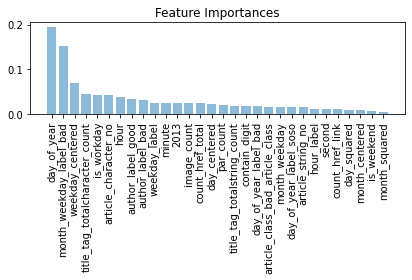

In [ ]:
xgboost.fit(X_combine[feature_used_rfe], y_new)
importances = xgboost.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_combine[feature_used_rfe].shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_combine[feature_used_rfe].columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_combine[feature_used_rfe].shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_combine[feature_used_rfe].shape[1]), 
           X_combine[feature_used_rfe].columns.values[indices], rotation=90)
plt.tight_layout()
plt.show()

### Ensemble Voting (Logistic Regression x RandomForest x XGBoost)

簡單了解一下voting的效過如何 (非主要模型)

In [ ]:
# Ensemble Voting

pipe1 = Pipeline([['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
pipe2 = Pipeline([['clf', RandomForestClassifier(criterion='entropy', n_estimators=200,n_jobs=-1, max_depth = 3, random_state = 0)]])
pipe3 = Pipeline([['clf', GradientBoostingClassifier(n_estimators=200, max_features=6, max_depth=5, random_state=0,learning_rate=0.015)]])

In [ ]:
clf_labels = ['LogisticRegression', 'Randomforest', 'XGBoost']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_combine[feature_used], y=y_new, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.608 (+/- 0.013)
Randomforest: 0.604 (+/- 0.016)
XGBoost: 0.617 (+/- 0.013)


In [ ]:
print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X[feature_used], y=y_new, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

## Combine useful features and TF-IDF to bulid model.

### Lightgbm with gridsearch

LightGBM使用一種全新的基於梯度的單側取樣（GOSS）技術來過濾資料例項，以尋找分割值。而XGBoost則是使用預分類演算法（presorted algorithm）和基於直方圖的演算法來計算最佳分割。由於GOSS保留所有具有大梯度的例項，並在具有小梯度的例項上執行隨機取樣，因此LightGBM在演算速度上比XGBoost還要快上一些。除此之外，為了保持相同的資料分佈，當計算資訊增益時，GOSS為小梯度的資料例項引入了一個常數乘數。因此，GOSS在減少資料例項的數量和保持學習決策樹的精確性之間取得了良好的平衡。基於上述理由，我們選擇LightGBM來建模，並搭配gridsearch來找出最佳參數。

In [ ]:
import pandas as pd
df_trn = pd.read_csv('./data/X_TRAIN.csv')
df_tst = pd.read_csv('./data/X_TEST.csv')
tidf_feature_trn = pd.read_csv('./data/X_train_tfidf_feature.csv')
tidf_feature_tst = pd.read_csv('./data/X_test_tfidf_feature.csv')

useful_feature = [
    'title_tag_totalcharacter_count',
    'title_tag_totalstring_count',
    'contain_digit',
    'punctuation_count_ex_que_col',
    'topic_len',
    'count_href_total',
    'count_href_link',
    'count_href_twitter',
    'month',
    'day',
    'weekday',
    'hour',
    'article_character_no',
    'article_string_no',
    'is_weekend',
    'par_count',
    'image_count',
    'hour_label',
    'month_label',
    'weekday_label',
    'day_of_year',
    'article_class_bad_article_class',
    'article_class_good_article_class',
    'day_of_year_label_bad',
    'day_of_year_label_good',
    'author_label_bad',
    'author_label_good',
    '2013',
    '2014']
X_trn = pd.concat([df_trn[useful_feature], tidf_feature_trn], axis=1)
y_trn = df_trn['Popularity'].values
y_trn = (y_trn + 1)/2

X_tst = pd.concat([df_tst[useful_feature], tidf_feature_tst], axis=1)

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import numpy as np

def lgb_cross(xtrn, ytrn, xtst, nfold, param):
    skf = StratifiedKFold(n_splits=nfold, shuffle=True)
    xtrn = xtrn.to_numpy()
    #pred_trn = []
    pred_val = np.zeros(xtrn.shape[0])
    pred_tst = np.zeros(xtst.shape[0])
    for i, (trn_index,val_index) in enumerate(skf.split(xtrn,ytrn)):
        print('Fold:{}'.format(i+1))
        cv_xtrn, cv_xval = xtrn[trn_index], xtrn[val_index]
        cv_ytrn, cv_yval = ytrn[trn_index], ytrn[val_index]
        
        gbm = lgb.LGBMClassifier(
            bagging_freq=1,
            learning_rate=0.005,
            n_estimators=1000,
            objective="binary",
            boosting_type="gbdt",
            metric="auc"
            )
        gs = GridSearchCV(estimator = gbm, param_grid = param, scoring='roc_auc', cv=5, n_jobs=7, verbose=2)
        gs.fit(cv_xtrn, cv_ytrn)
          
        #pred_trn.append(gs.best_score_)
        pred_val[val_index] = gs.predict_proba(cv_xval)[:,1]
        #print('Train auc: %.5f' % (pred_trn[i]))
        #print('Validate auc: %.5f' % (pred_val[i]))
        print("Best parameters:{}".format(gs.best_params_))
        
        pred_tst += gs.predict_proba(xtst)[:,1]/nfold
        
    return pred_val, pred_tst

In [ ]:
param_cv = {
    'num_leaves': [20,32,40],
    "min_data_in_leaf": [40,50,60,70],
    "feature_fraction": [0.3,0.5,0.8,1],
    "bagging_fraction":[0.3,0.6,0.8,1],
}

xtrn_pred, y_pred = lgb_cross(xtrn = X_trn,
                ytrn = y_trn, 
                xtst = X_tst, 
                nfold = 5, 
                param = param_cv)

5-fold CV 平均AUC為0.5926, 在public board上的結果為0.58736。

### Staking
由於 Stacking 可使用 meta model 求多個 Classifiers 的 Voting Weight，故結合 Creative Variables + TF-IDF + XGboost + LightGBM ，其中 XGboost、LightGBM 的 hyperparameters 為前面模型 Grid Search 結果。

* Stacking model　原先未加 tf-idf 所得的200個變數時，5-fold CV 平均 AUC 為0.594，在 public board 上的結果為0.58024, 在 private board上的結果為 0.58606。


* 加入 tf-idf 所得的200個變數後，5-fold CV 平均 AUC 為0.60, 在 public board 上的結果為0.58559, 在 private board上的結果為 0.59055。


In [ ]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('LGBM', LGBMClassifier()))
    level0.append(('XGB', GradientBoostingClassifier()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['LGBM'] = LGBMClassifier(bagging_freq=1,
                        learning_rate=0.005,
                        n_estimators=500,
                        objective="binary",
                         boosting_type="gbdt",
                         metric="auc",
                          bagging_fraction=0.5, 
                           feature_fraction=0.5,
                           min_data_in_leaf=60,
                            num_leaves=20)
    models['XGB'] = GradientBoostingClassifier(min_samples_leaf=100,
                                      min_samples_split=0.01,
                                      max_depth=9,
                                       learning_rate=0.01,
                                      max_features=10,
                                       subsample=0.7)
    models['stacking'] = get_stacking()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)
    outer_scores = []
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        print('[Outer fold %d/5]' % (i + 1))
        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]
        pipe = Pipeline([['clf', model]])
        pipe.fit(X_train, y_train)
        outer_scores.append(pipe.score(X_test, y_test))
#         print('Test accuracy: %.2f ' % (outer_scores[i]))
    return outer_scores
#%%
# define dataset
X,y= X_TRAIN,y_new#get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
#%%
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# ***The Most Important features***

* **文章的長短**: 文章越長傾向於越不popular
* **day of year**: 此變數1-365天刻劃了一年中的所有假日、節日
* **weekday**: 1-4較不傾向於popular，5傾向於popular，6-7非常傾向於popular


# ***Conclusion***

1. **Feature Engineering 時最好的參考依據：Popularity Ratio 即** $N(X_i=x_{ij}|Y=1)/N(X_i = x_{ij})$ 
  * 當poplularity ratio在某些變數下有異於0.5的狀況發生可能就代表著他是個重要變數(e.g. 假日、1-5月等)；要注意的是某些類別的popularity ratio雖高但樣本數並不足夠或ratio只略高過50%。在這樣的情況下，此變數可能並不顯著，也就是說，無法拒絕p=0.5的虛無假設，這時若認為此變數為重要變數，好則無用壞則造成overfitting。故我們通常會要求在特定類別下 $x_{ij}$ 滿足一定樣本數，以及popularity ratio達到 $0.55$ 甚至 $0.6$ 以上才會認為此變數(類別)有助於提升某文章被classify為popular的可能性。
2. **可以透過common sense做feature engineering**
  * 一個日常生活中的題目例如這次的預測文章是否為popular通常都可以用常識去做一些feature engineering，例如我們可以理性的認為文章的長短，標題的長短會影響一篇文章是否熱門等。潛在危機是，他可能因此讓我們錯失一些data driven的變數，例如我們會認為說假日民眾比較有時間可以觀看文章，故假日發表的文章可能會較popular，based on 我們的EDA也的確是如此，然而我們的EDA還多告訴了我們禮拜五也是一個小假日，這天發表的文章的也比星期一到四更加容易變成popular。
3. **Feature重質不重量**
  * 一個好的feature勝過幾千萬個無用的features，應該花更多時間再EDA以及logical的特徵萃取上，真正要衝分時，再使用technical的技巧，我們原先大約用了20+個變數可以達到private LB 0.595以上的成績，再輔以tf-idf的方法讓我們得以再提升一點。
3. **相信CV**
  * Public Leaderboard只是一個參考，雖不失為一個評量模型好壞的依據，但若Private Leaderboard使用的資料分配與Public差距太大，則最終結果將有很大的差異。
  * 再者，現實生活中並沒有所謂的Public或Private Leaderboard這些參考依據，只要專注在我們手中的資料，確保每個環節合理，以及資料切分時的妥當性(對於training不要錯失general pattern，對於validation跟testing不要讓他們的分配過於特殊)，最終得出的CV score即為最可靠的參考依據。事實上資料切分時絕對不要只切出各一組training, validation, 以及testing set, 只要效能以及時間許可，盡量都用k-fold 或 stratified k-fold(for unbalanced data)的方式以確保我們沒有被特殊的切分誤導。甚至，我們可以對k-fold 或 stratified k-fold中random state跑幾個迴圈，來保證我們在滿足reproduce result的同時又可以使我們的performance metric更具代表性(當deploy model on a new data set).
4. **對於Kaggle比賽，選前三高的public LB分數作為最終的prediction result除非public跟private LB的資料用量差距太大(例如: public: $20\%$, private: $80\%$)**
  * 這其實有點experience-driven，有些文章或人會告訴我們選prediction result分配差距比較大且Public LB達到一定水準的(可能差距在0.05左右的depends on metrics and task(dataset))，但事實上若在process的過程中都很小心的處理確保不會造成太嚴重的overfitting發生的情況下，些許overfitting的public LB的prediction也會表現得比沒有overfitting的另一種分配且分數比較低的prediction result在private LB表現上來的好。(例如：(Public -> Private) 0.82->0.813 > 0.807->0.811)，而事實上，高分的也並不一定會overfitting。


## ***Remarks*** 
以下結果為我們conclusion 3,4,5的主要依據:

1. 可以發現到public LB的資料分配嚴重影響我們的實際結果，可能因為我們feature engineering的關係造成出來的模型很不fit Public Leaderboard所挑選出的testing data以致於僵持在0.587左右無法提升。
  * <font color = "gray">若Public LB和Private LB所使用的testing data不互斥，或public LB上實際上用了少於50%的資料，則代表著我們可能被public特殊的分配給影響了最終的結果；但若是皆只用了互斥的50%testing data，代表我們模型與其他組相比還有很多進步空間，因為真實情況下，不論Public或Private都是我們未知的新資料，也代表著我們在某一部分的新資料上表現不是很好。 </font>
2. 其中有幾個是只用了20+個變數，就可以在Private LB上達到很好的效果，而表現最好的第5個result為加入tf-idf的成績，故衝分時有一些比較技術上的方法是很好的。

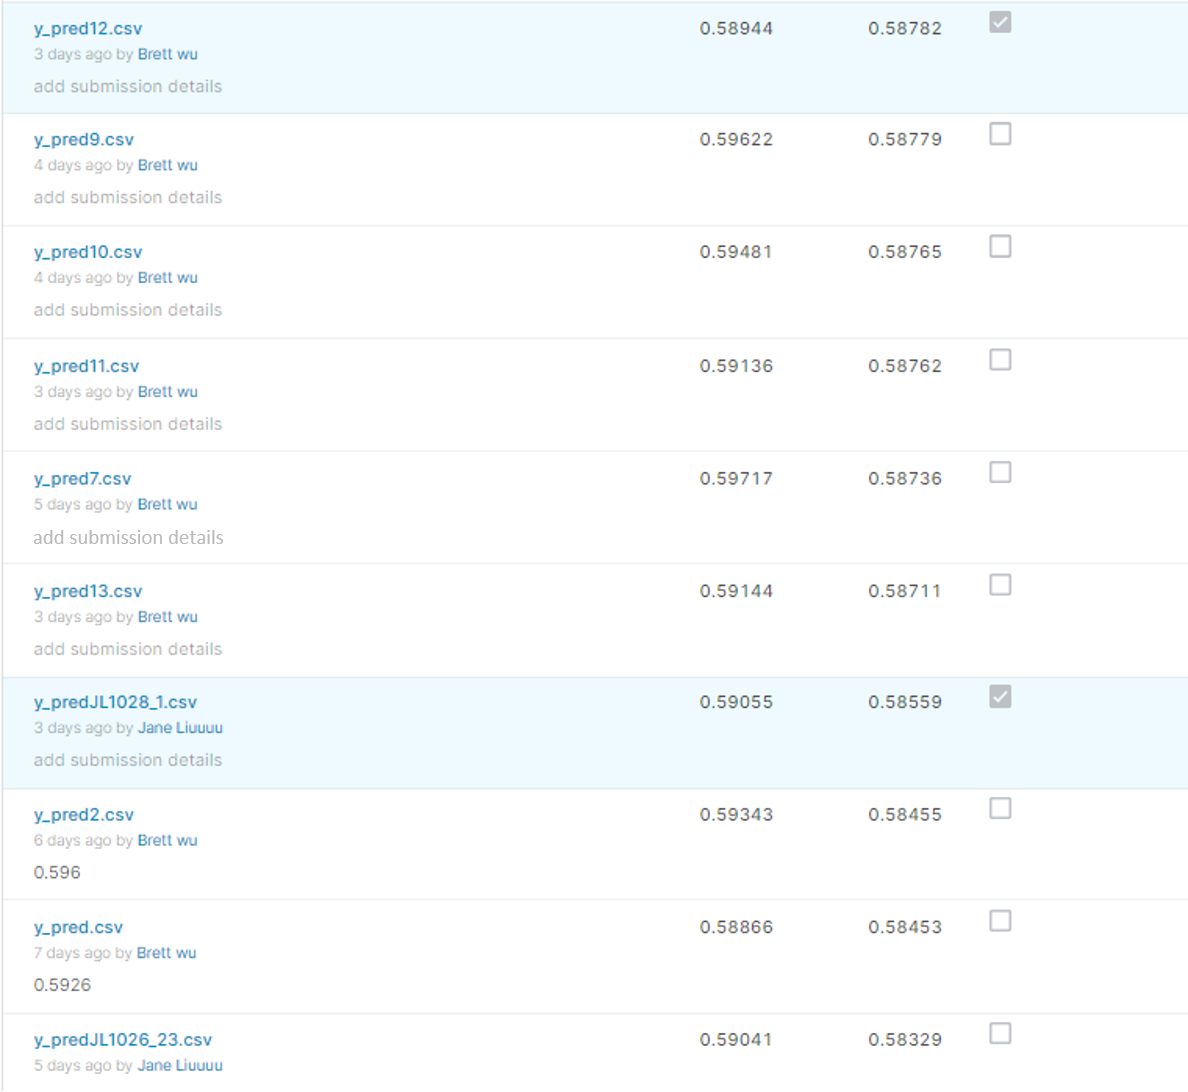